# 95835-A5 Time Series Forecasting in Python

## Group Project: <font color='blue'> "Hotel Occupancy and Fereign Visitors Forecast" </font>

## Group Members: <font color='blue'> Antara Saha, Carlos Lopez Uribe, Jinzo Nakakawa, Masu Masukata. </font>

## Date: <font color='blue'> June 19th, 2023 </font>

## 1. Import Packages

In [13]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt #viz #GUI manager
import seaborn as sns #viz #plotly is another package
from statsmodels.graphics.tsaplots import plot_acf #autocorrelation plot
import statsmodels.api as sm 
from statsmodels.graphics.tsaplots import plot_acf #autocorrelation plot
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing # double and triple exponential smoothing
from pandas.plotting import autocorrelation_plot #autocorrelation plot
from statsmodels.graphics.gofplots import qqplot #residual diagnostics
from sklearn.metrics import mean_squared_error #accuracy metrics
from math import sqrt
from sklearn.metrics import mean_absolute_error #accuracy metrics
import pmdarima as pm #auto arima
from sklearn.model_selection import train_test_split

## 2. Hotel Dataset

- The Mexican Secretary of Tourism (Spanish: Secretaría de Turismo, SECTUR) is the government department in charge of the nation's tourism promotion and development.
- Internationally, the "percentage of occupancy" measures the hotel performance at a specific region.
- The "DataTour Monitoring System" belongs to the Mexican Secretary of Tourism and reports the occupancy status of the main tourism locations in Mexico.
- In this project, we are downloading a dataset from the "DataTour Monitoring System". The dataset consists of various time series of the occupancy percentage in Los Cabos, Baja California Sur, Mexico: Total, Local and Foreign Occupancy Percentages.

Link: https://www.datatur.sectur.gob.mx/SitePages/ActividadHotelera.aspx

### 2.1 Import Hotel Dataset

In [4]:
lc_occupancy = pd.read_csv('los_cabos_occupancy.csv', usecols=['DATE', 'Total_Occupancy_Percentage',
                                                               'Local_Occupancy_Percentage', 
                                                               'Foreign_Occupancy_Percentage'])

In [5]:
lc_occupancy

,DATE,Total_Occupancy_Percentage,Local_Occupancy_Percentage,Foreign_Occupancy_Percentage
0,Enero 2012,65.79,8.56,57.23
1,Febrero 2012,74.65,9.39,65.26
2,Marzo 2012,79.33,9.78,69.55
3,Abril 2012,71.88,14.83,57.05
4,Mayo 2012,59.65,11.97,47.68
...,...,...,...,...
131,Diciembre 2022,73.73,9.38,64.35
132,Enero 2023,83.49,6.98,76.51
133,Febrero 2023,85.20,9.54,75.66
134,Marzo 2023,84.91,8.75,76.16


## 3. Converting Hotel Dataset into Time Series Format

In [6]:
lc_occupancy_df = lc_occupancy.set_index(pd.date_range('2012-01-01', '2023-04-01', freq='MS'))
lc_occupancy_df = lc_occupancy_df.drop(columns=['DATE'])
lc_occupancy_df = lc_occupancy_df[:datetime(2019, 12, 1)]
lc_occupancy_df

,Total_Occupancy_Percentage,Local_Occupancy_Percentage,Foreign_Occupancy_Percentage
2012-01-01,65.79,8.56,57.23
2012-02-01,74.65,9.39,65.26
2012-03-01,79.33,9.78,69.55
2012-04-01,71.88,14.83,57.05
2012-05-01,59.65,11.97,47.68
...,...,...,...
2019-08-01,59.71,16.23,43.48
2019-09-01,44.33,11.13,33.20
2019-10-01,69.43,17.00,52.43
2019-11-01,74.28,17.15,57.13


## 4. Exploratory Data Analysis (EDA) for Hotel Occupancy

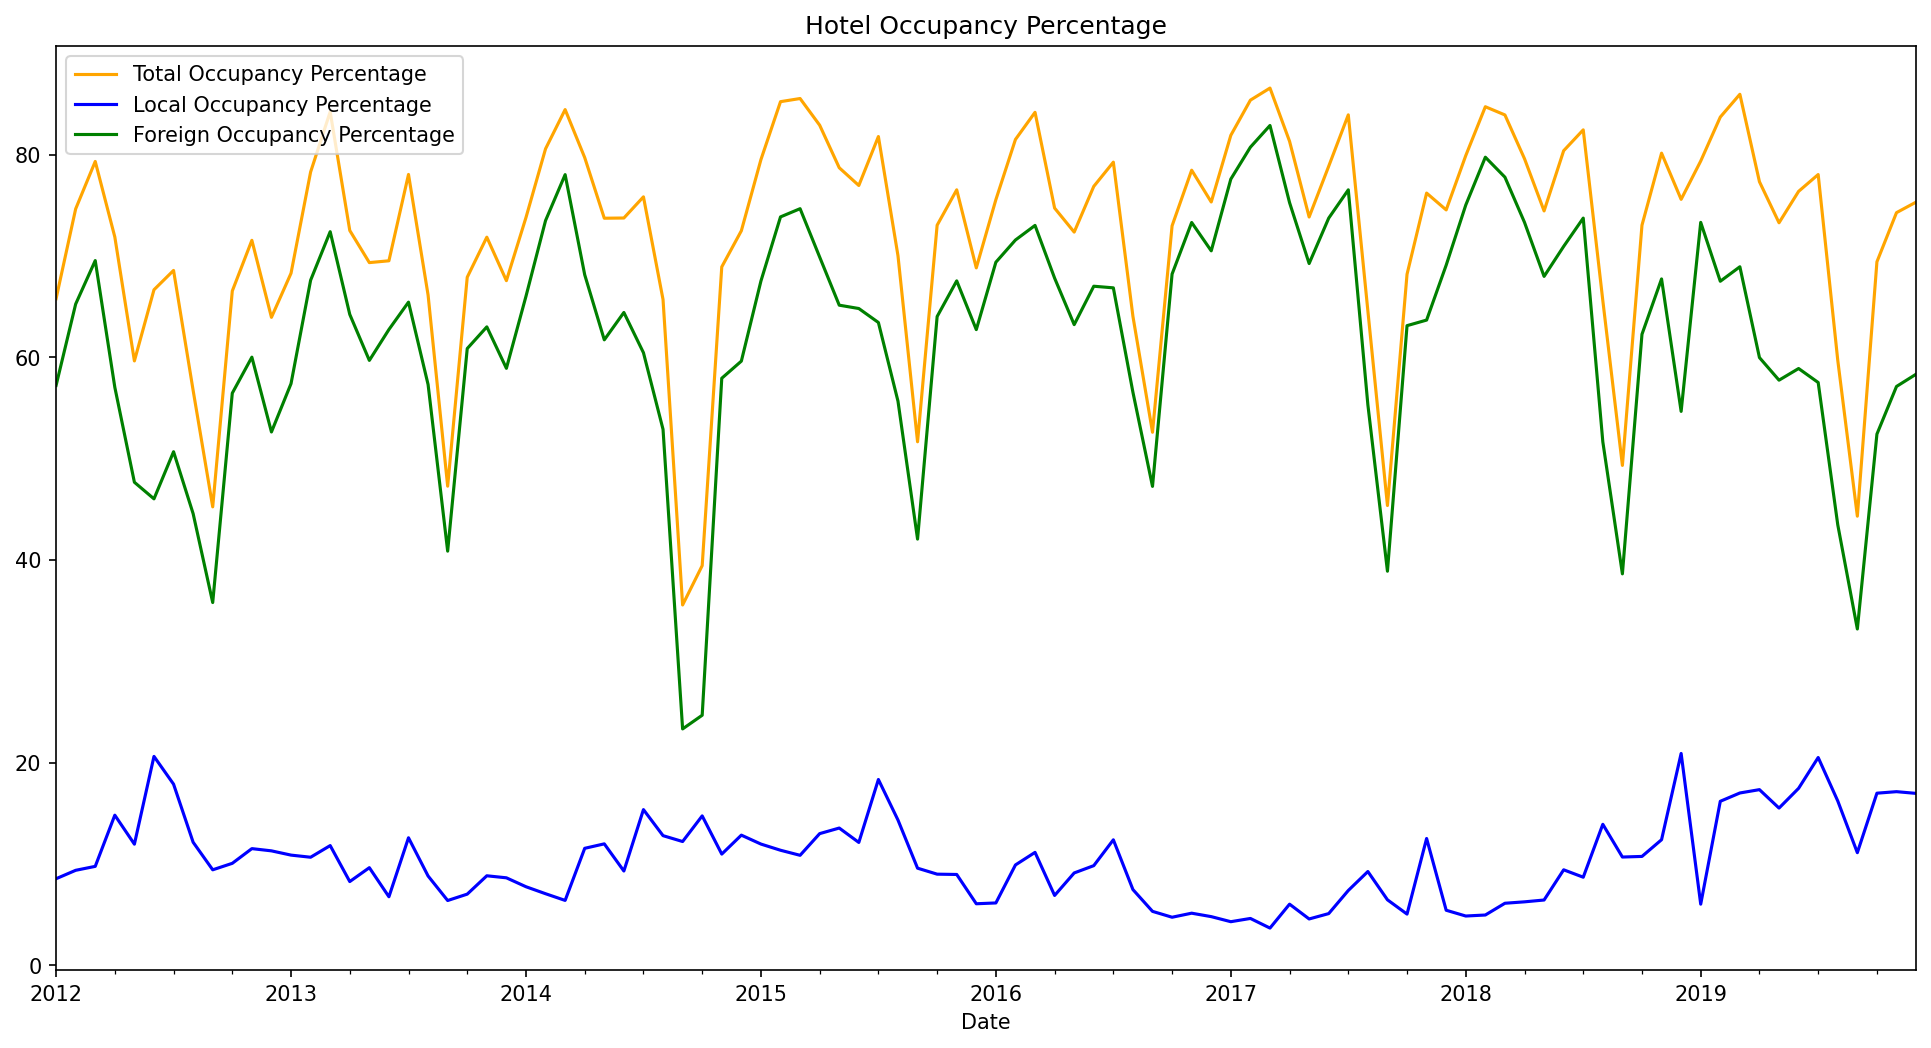

In [7]:
# Visualizing The Close Price of the stocks
  
# to set the plot size
plt.figure(figsize=(16, 8), dpi=150) #dpi = resolution. default 100.
  
# using plot method to plot close prices.
# in plot method we set the label and color of the curve.
lc_occupancy_df['Total_Occupancy_Percentage'].plot(label='Total Occupancy Percentage', color='orange')
lc_occupancy_df['Local_Occupancy_Percentage'].plot(label='Local Occupancy Percentage', color='blue')
lc_occupancy_df['Foreign_Occupancy_Percentage'].plot(label='Foreign Occupancy Percentage', color='green')
  
# adding title to the plot
plt.title('Hotel Occupancy Percentage')
  
# adding Label to the x-axis
plt.xlabel('Date')
  
# adding legend to the curve
plt.legend()

<Axes: ylabel='Total_Occupancy_Percentage'>

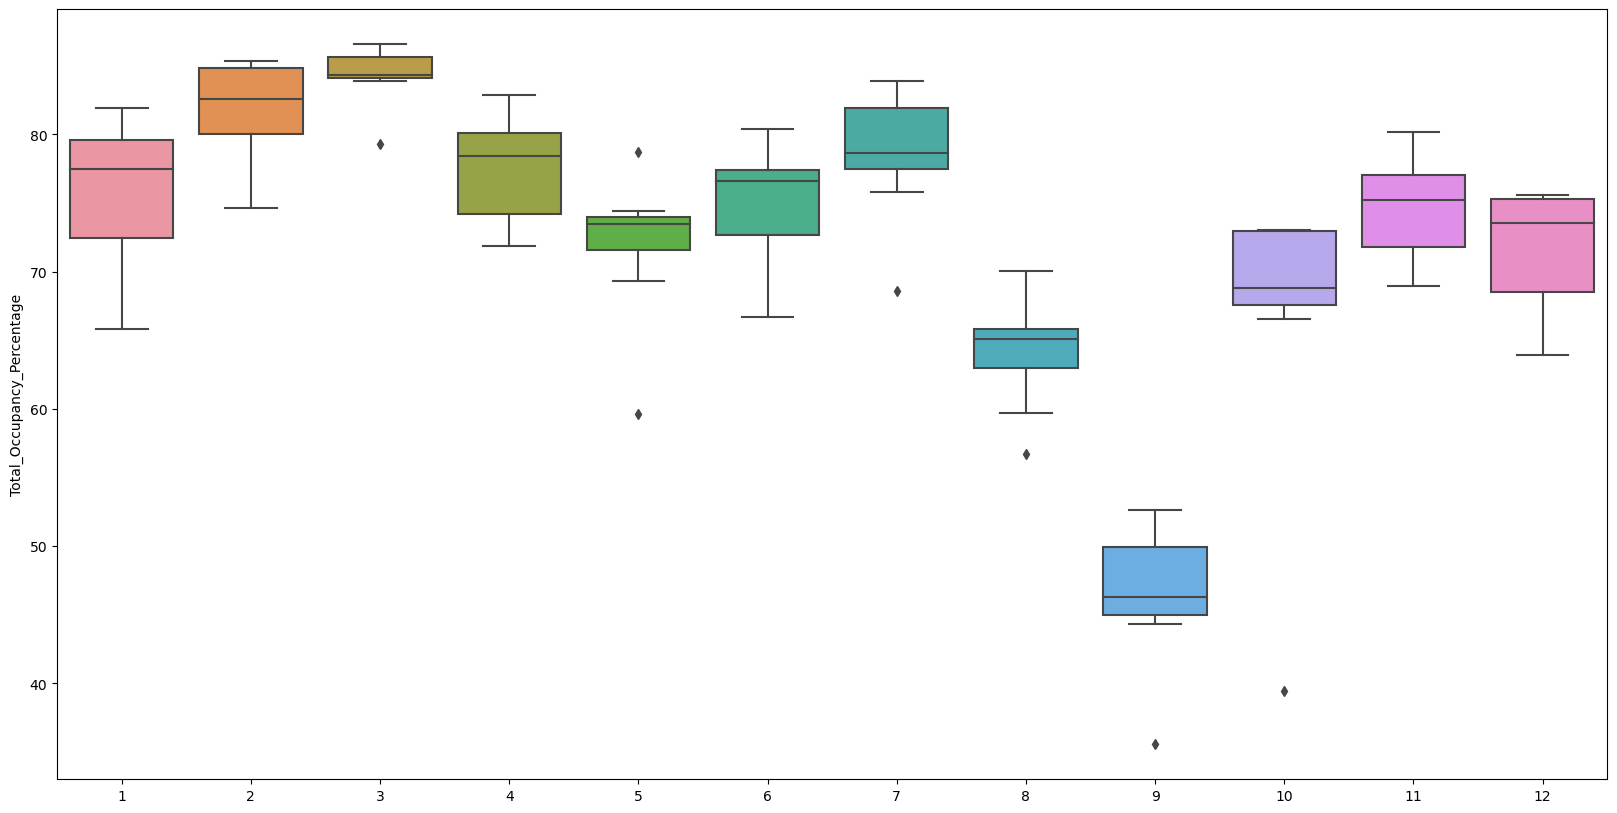

In [8]:
# Monthly Occupancy for Resort Hotel

fig, ax = plt.subplots(figsize=(20,10))
sns.boxplot(x = lc_occupancy_df['Total_Occupancy_Percentage'].index.month,
                y = lc_occupancy_df['Total_Occupancy_Percentage'], 
                ax = ax)

<Axes: ylabel='Total_Occupancy_Percentage'>

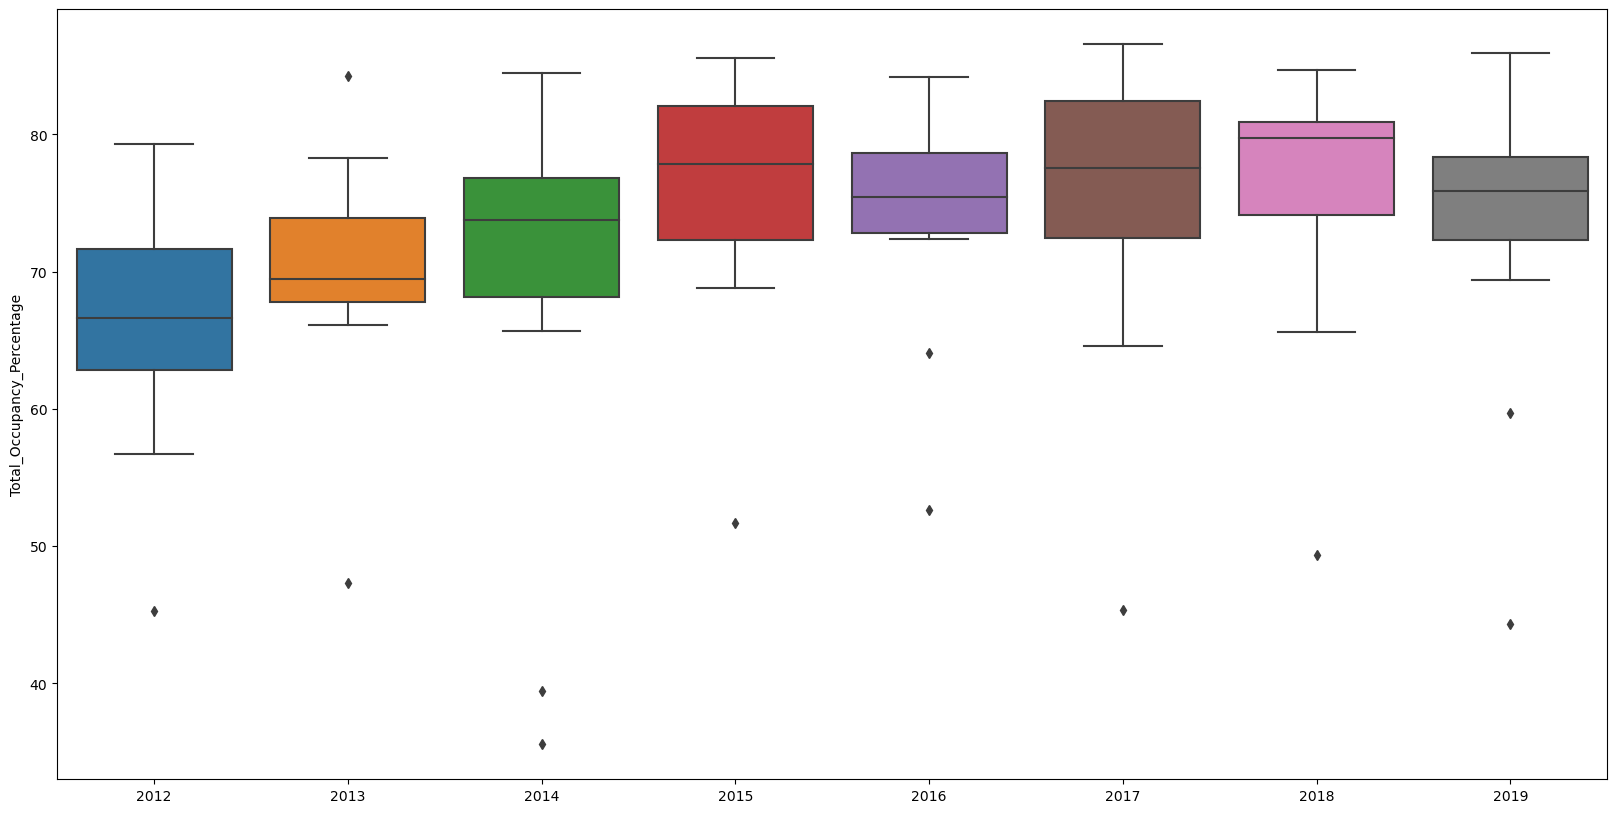

In [9]:
# Yearly Occupancy

fig, ax = plt.subplots(figsize=(20,10))
sns.boxplot(x = lc_occupancy_df['Total_Occupancy_Percentage'].index.year,
                y = lc_occupancy_df['Total_Occupancy_Percentage'], 
                ax = ax)

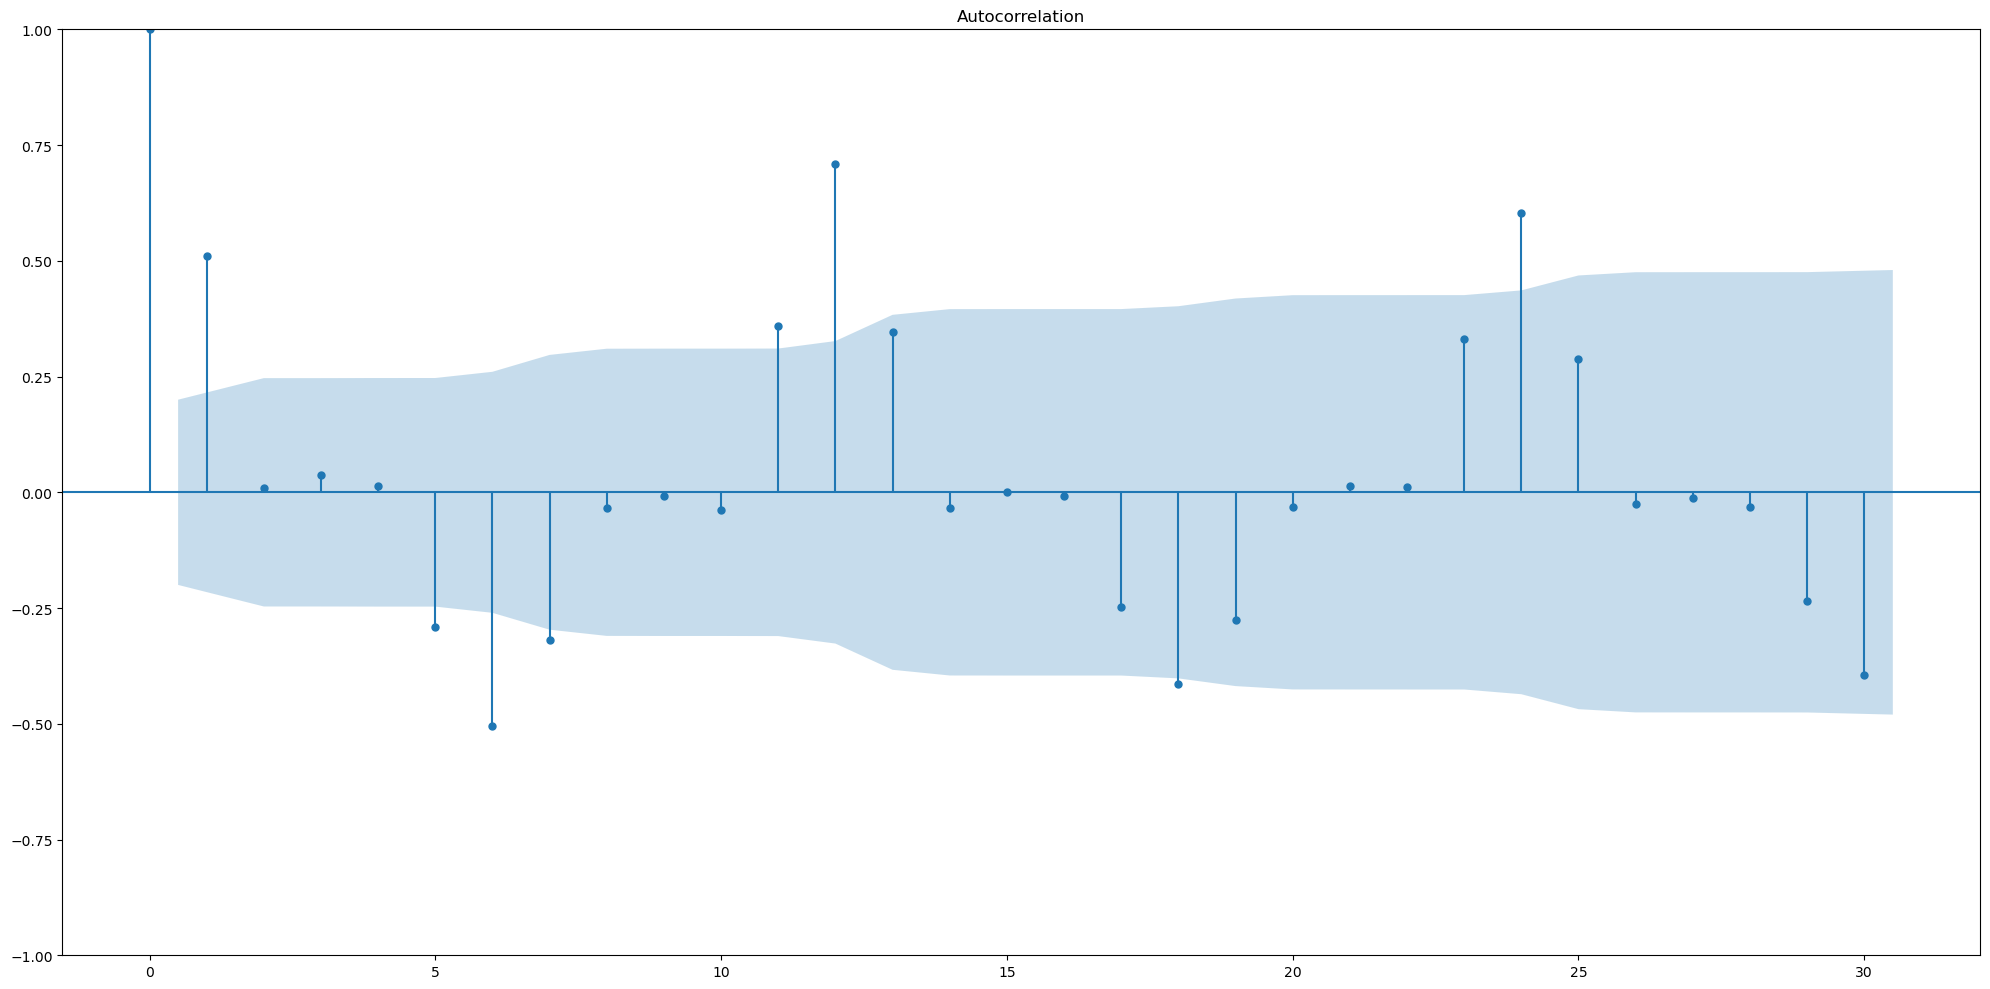

In [10]:
# Autocorrelation or ACF plot for Occupancy in Resort Hotel

fig = plot_acf(lc_occupancy_df['Total_Occupancy_Percentage'], lags=30)
fig.set_size_inches((20, 10))
# Tight layout to realign things
fig.tight_layout()
plt.show()

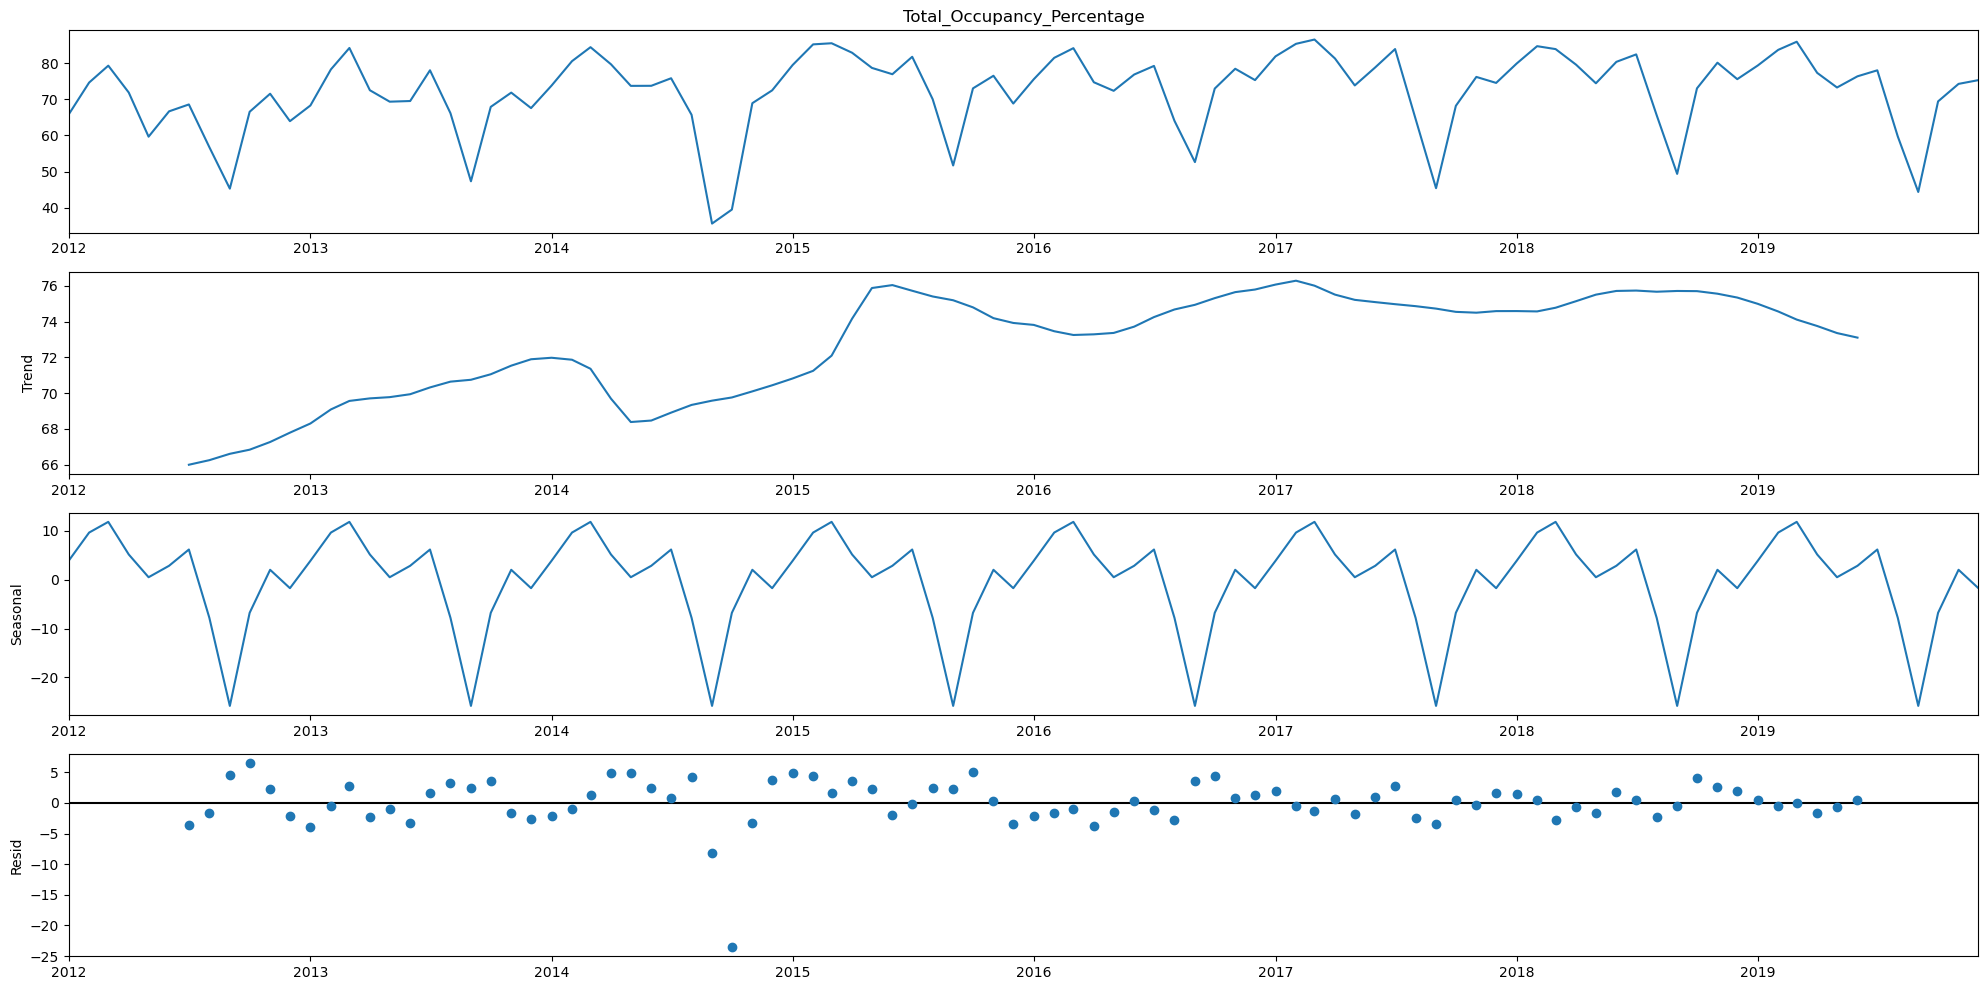

In [11]:
# Time Series Decomposition

res = sm.tsa.seasonal_decompose(lc_occupancy_df['Total_Occupancy_Percentage'], period=12)
fig = res.plot()
fig.set_size_inches((20, 10))
# Tight layout to realign things
fig.tight_layout()
plt.show()

## 5. Split Hotel Occupancy Data into Train and Test Sets

In [14]:
# Create a test set of 12 data points
test_size = 12

train_data, test_data = train_test_split(lc_occupancy_df['Total_Occupancy_Percentage'], test_size=test_size, random_state=25, shuffle = False)
#shuffle = False is very important to ensure the order of the data

print(f"No. of training examples: {train_data.shape[0]}")
print(f"No. of testing examples: {test_data.shape[0]}")

No. of training examples: 84
No. of testing examples: 12


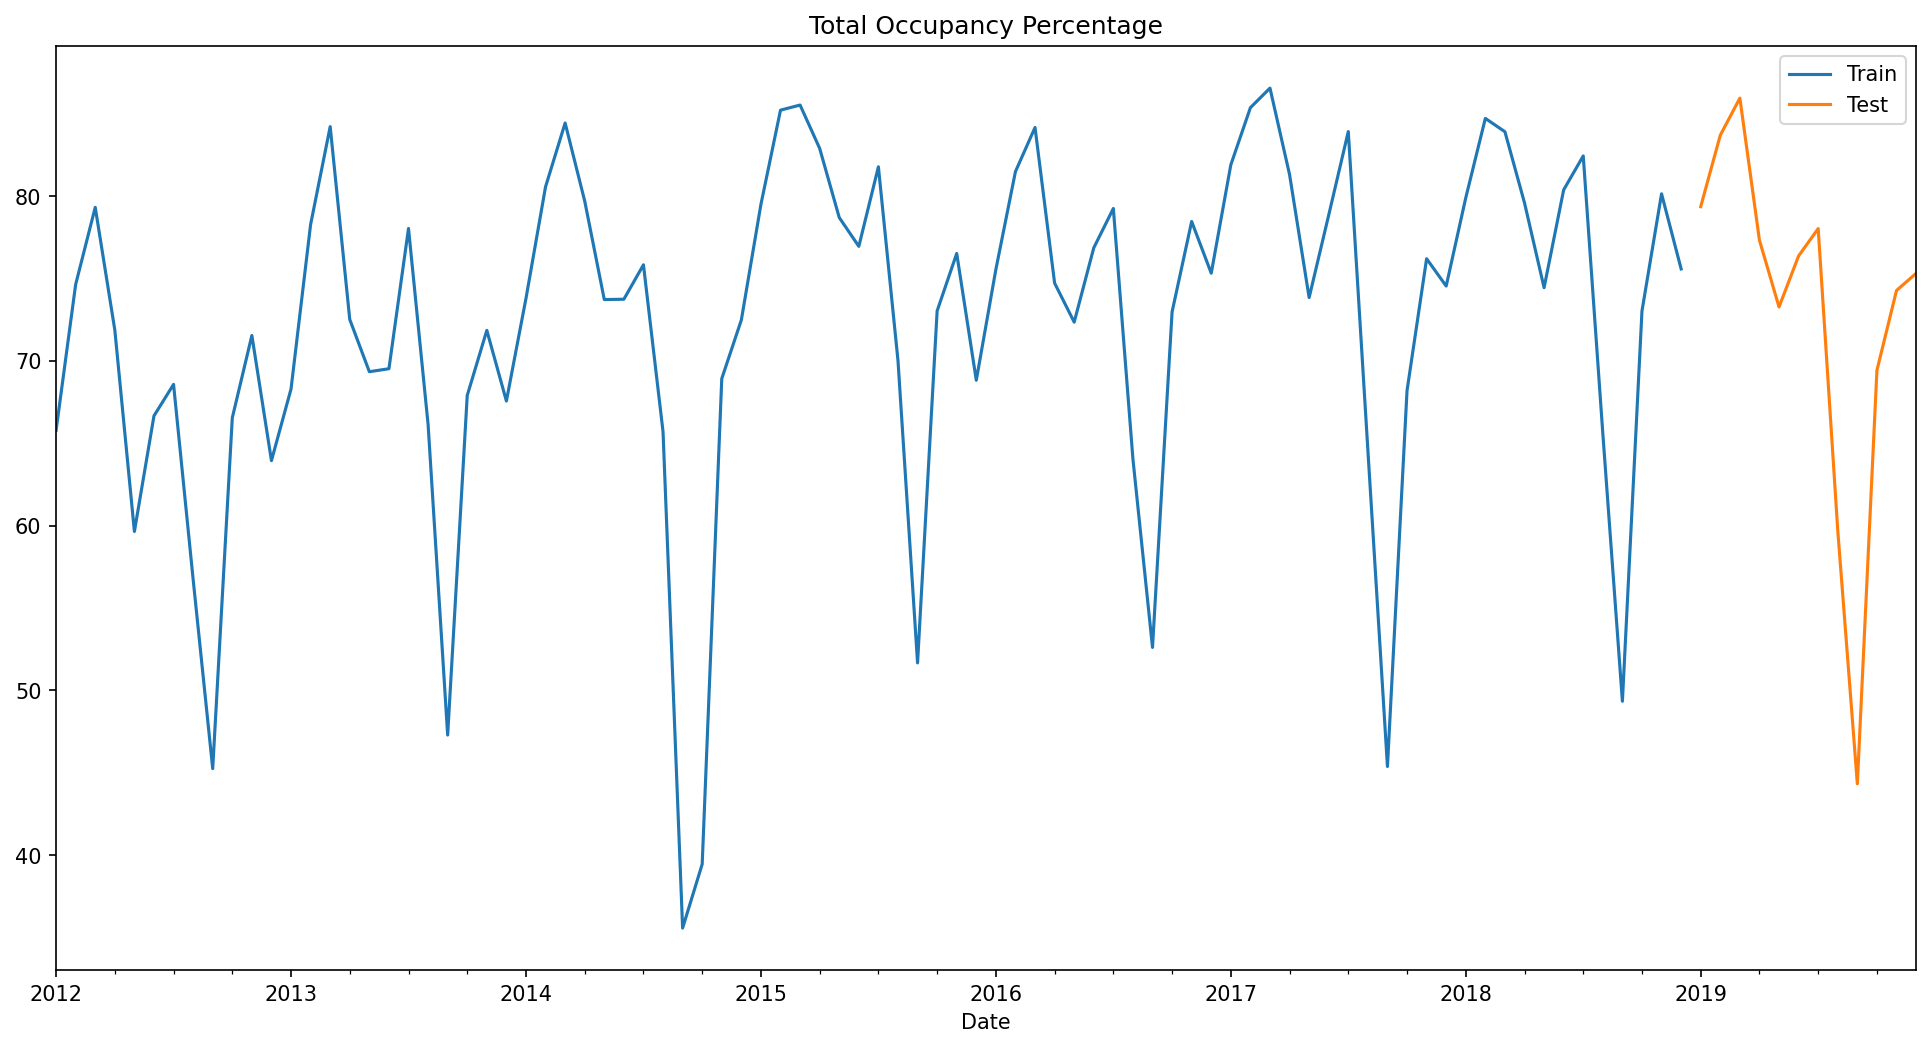

In [15]:
#Plot train and test data

# to set the plot size
plt.figure(figsize=(16, 8), dpi=150)
  
# using plot method to plot close prices.
# in plot method we set the label and color of the curve.
train_data.plot(label='Train')
test_data.plot(label='Test')

  
# adding title to the plot
plt.title('Total Occupancy Percentage')
  
# adding Label to the x-axis
plt.xlabel('Date')
  
# adding legend to the curve
plt.legend()

## 6. Model Fitting for Hotel Occupancy

### Simple Exponential Smoothing

In [16]:
#Third Instance
simple_ets_opt = SimpleExpSmoothing(train_data).fit()
simple_ets_opt_pred = simple_ets_opt.forecast(12).rename('alpha=%s'%simple_ets_opt.model.params['smoothing_level'])

In [17]:
simple_ets_opt_pred

2019-01-01    75.590015
2019-02-01    75.590015
2019-03-01    75.590015
2019-04-01    75.590015
2019-05-01    75.590015
2019-06-01    75.590015
2019-07-01    75.590015
2019-08-01    75.590015
2019-09-01    75.590015
2019-10-01    75.590015
2019-11-01    75.590015
2019-12-01    75.590015
Freq: MS, Name: alpha=0.9999967919934124, dtype: float64

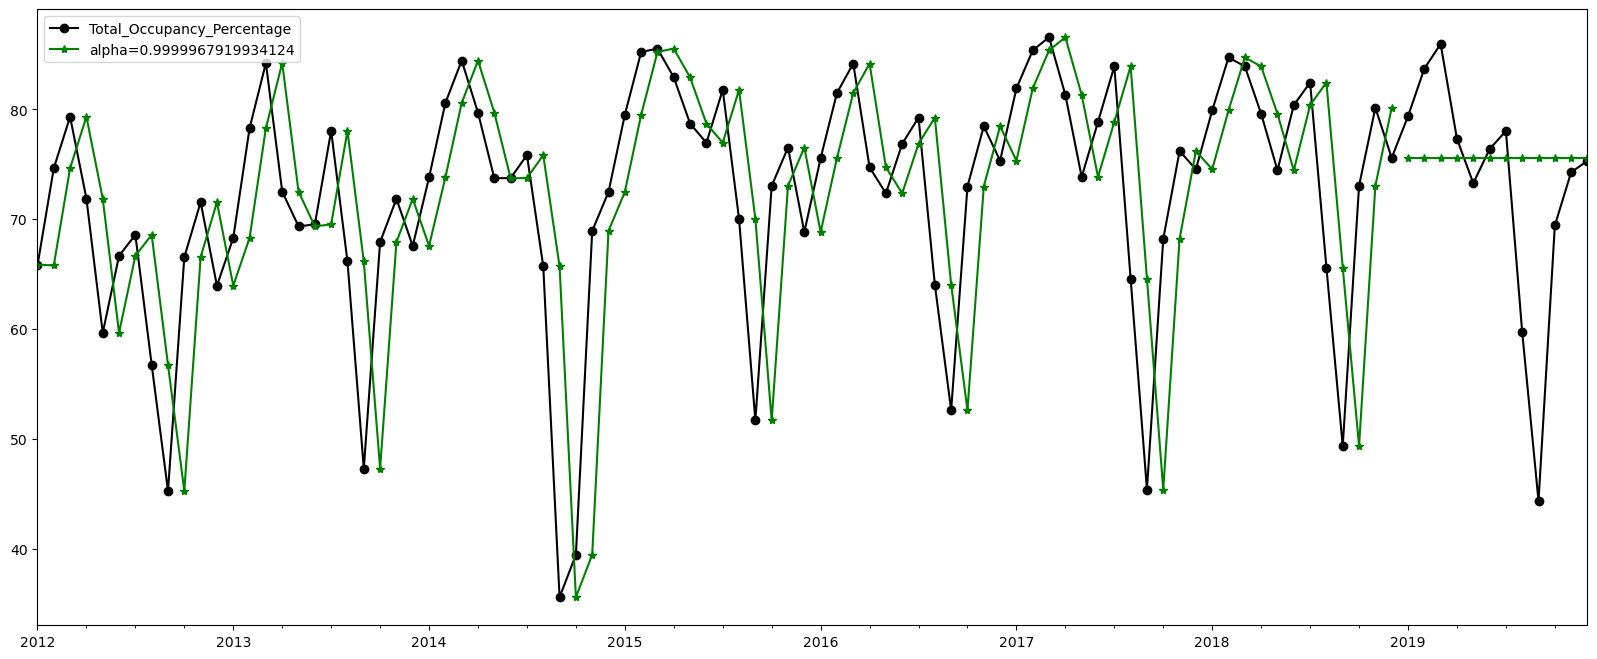

In [18]:
#After creating model we will visualize the plot
ax = lc_occupancy_df['Total_Occupancy_Percentage'].plot(marker='o', color='black', figsize=(20,8), legend=True)

#Plot for alpha=Optimized by statsmodel
simple_ets_opt_pred.plot(marker='*', ax=ax, color='green', legend=True)
simple_ets_opt.fittedvalues.plot(marker='*', ax=ax, color='green')

plt.show()

### Double Exponential Smoothing

In [19]:
# Double ETS
double_ets_add = ExponentialSmoothing(train_data, trend = 'add').fit()
double_ets_mul = ExponentialSmoothing(train_data, trend = 'mul').fit()

double_ets_add_pred = double_ets_add.forecast(12)
double_ets_mul_pred = double_ets_mul.forecast(12)

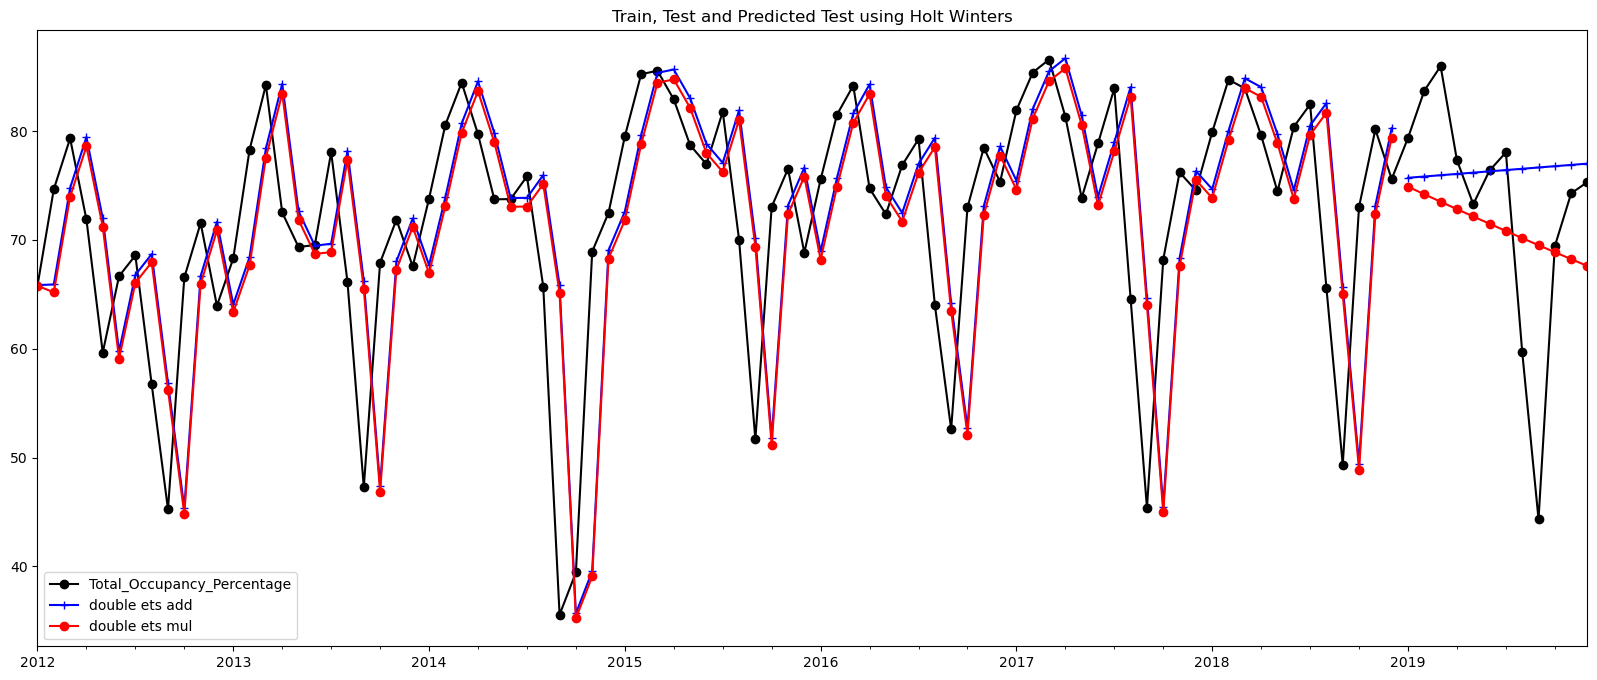

In [20]:
#plot the train, test, and predictions

#After creating model we will visualize the plot
ax = lc_occupancy_df['Total_Occupancy_Percentage'].plot(marker='o', color='black', figsize=(20,8), legend=True)

#Plot for double ETS additive
double_ets_add_pred.plot(marker='+', ax=ax, color='blue', legend=True, label = 'double ets add')
double_ets_add.fittedvalues.plot(marker='+', ax=ax, color='blue')

#Plot for double ETS multiplicative
double_ets_mul_pred.plot(marker='o', ax=ax, color='red', legend=True, label = 'double ets mul')
double_ets_mul.fittedvalues.plot(marker='o', ax=ax, color='red')

plt.title('Train, Test and Predicted Test using Holt Winters')
plt.show()

### Triple Exponential Smoothing

In [21]:
# triple ETS - Holt Winter's Seasonal Method
triple_ets_add = ExponentialSmoothing(train_data, trend = 'add', seasonal = 'add', seasonal_periods=12).fit()
triple_ets_mul = ExponentialSmoothing(train_data, trend = 'mul', seasonal = 'mul', seasonal_periods=12).fit()

triple_ets_add_pred = triple_ets_add.forecast(12)
triple_ets_mul_pred = triple_ets_mul.forecast(12)

C:\Users\julio\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


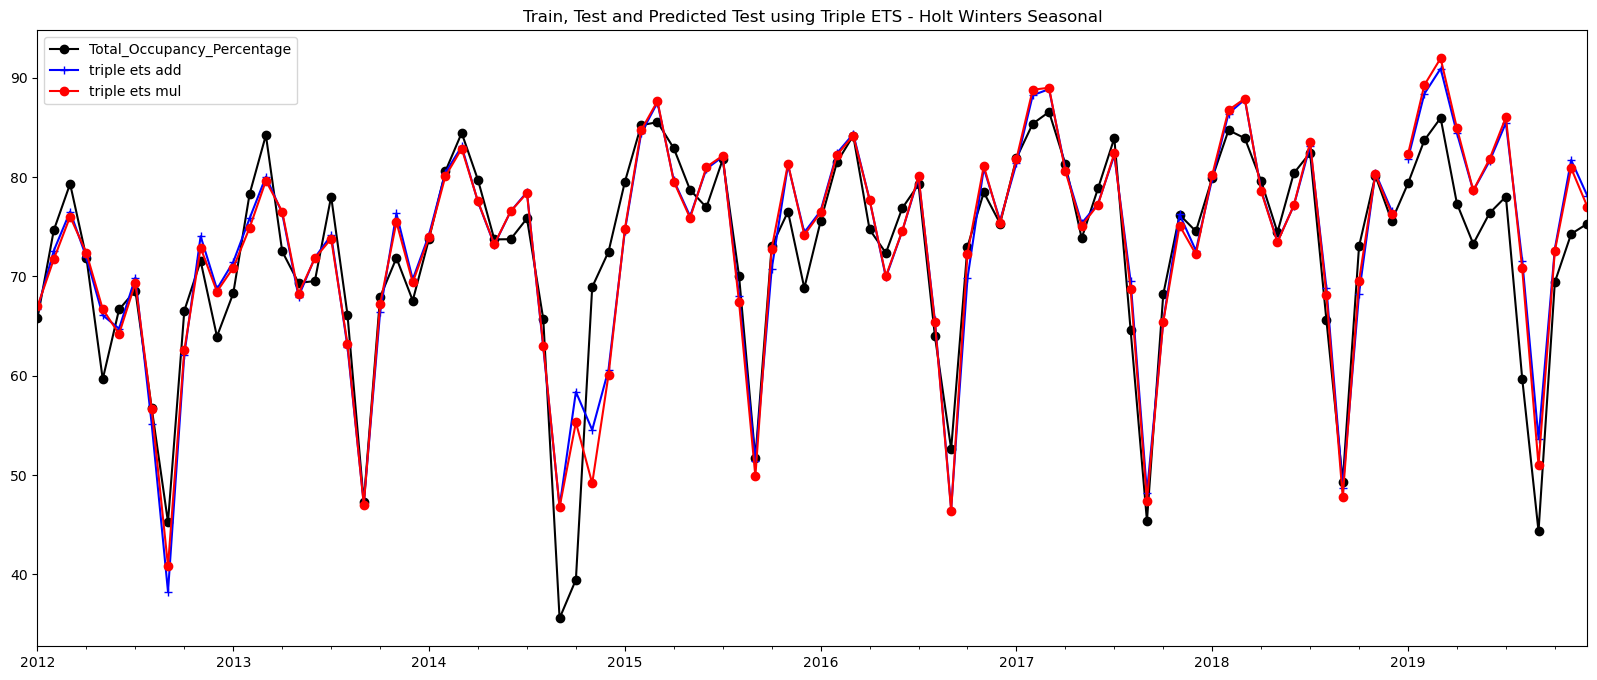

In [22]:
#plot the train, test, and predictions

#After creating model we will visualize the plot
ax = lc_occupancy_df['Total_Occupancy_Percentage'].plot(marker='o', color='black', figsize=(20,8), legend=True)

#Plot for double ETS additive
triple_ets_add_pred.plot(marker='+', ax=ax, color='blue', legend=True, label = 'triple ets add')
triple_ets_add.fittedvalues.plot(marker='+', ax=ax, color='blue')

#Plot for double ETS multiplicative
triple_ets_mul_pred.plot(marker='o', ax=ax, color='red', legend=True, label = 'triple ets mul')
triple_ets_mul.fittedvalues.plot(marker='o', ax=ax, color='red')

plt.title('Train, Test and Predicted Test using Triple ETS - Holt Winters Seasonal')
plt.show()

### Auto Arima Seasonal

In [23]:
# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(train_data, start_p=0, start_q=0,
                         test='adf',
                         max_p=4, max_q=4, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=473.177, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=462.790, Time=0.05 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.22 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=474.608, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=450.217, Time=0.14 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=0.75 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.27 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=449.128, Time=0.12 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=460.920, Time=0.04 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=0.47 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.23 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=447.336, Time=0.15 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=462.316, Time=0.07 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=447.197, Time=

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   84
Model:             SARIMAX(0, 1, 1)x(2, 1, 1, 12)   Log Likelihood                -218.599
Date:                            Mon, 19 Jun 2023   AIC                            447.197
Time:                                    10:00:26   BIC                            458.510
Sample:                                01-01-2012   HQIC                           451.696
                                     - 12-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4256      0.059     -7.258      0.000      -0.541      -0.311
ar.S.L12      -0.2489      0.215     -1.160      0.246      -0.670       0.172
ar.S.L24      -0.3170      0.159     -2.000      0.046      -0.628      -0.006
ma.S.L12      -0.6128      0.357     -1.716      0.086      -1.313       0.087
sigma2        22.5308      4.622      4.874      0.000      13.471      31.590
===================================================================================
Ljung-Box (L1) (Q):                   1.78   Jarque-Bera (JB):                32.80
Prob(Q):                              0.18   Prob(JB):                         0.00
Heteroskedasticity (H):               0.29   Skew:                            -0.42
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [24]:
# Forecast
n_periods = 12
fc_auto_seasonal, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)

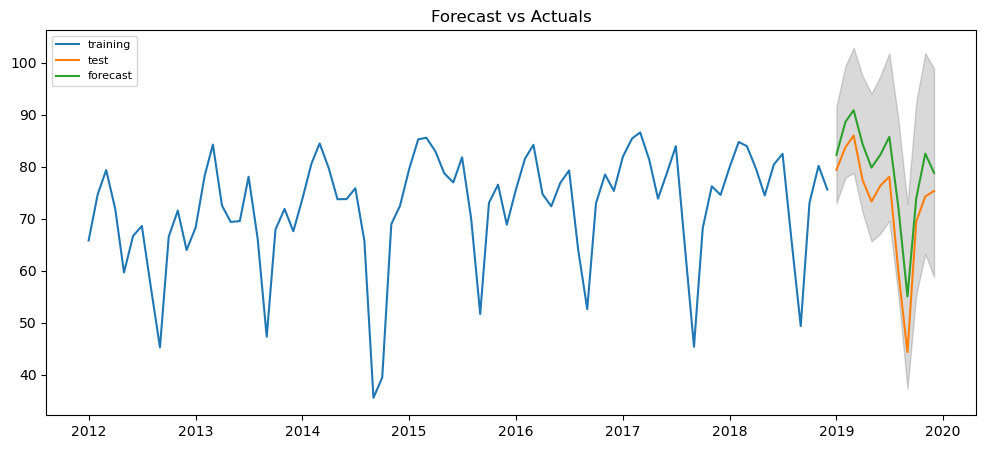

In [25]:
# make series for plotting purpose
fc_series_auto_seasonal = pd.Series(fc_auto_seasonal, index=test_data.index)
lower_series = pd.Series(confint[:, 0], index=test_data.index)
upper_series = pd.Series(confint[:, 1], index=test_data.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, label='test')
plt.plot(fc_series_auto_seasonal, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [26]:
fc_auto_seasonal

2019-01-01    82.273735
2019-02-01    88.600799
2019-03-01    90.822495
2019-04-01    84.229800
2019-05-01    79.803732
2019-06-01    82.324850
2019-07-01    85.712134
2019-08-01    72.124456
2019-09-01    55.049275
2019-10-01    73.889437
2019-11-01    82.484260
2019-12-01    78.794747
Freq: MS, dtype: float64

## 8. Hotel Occupancy Model Evaluation (Long Term - 12 Months)

In [27]:
#define metrics dataframe which will be used below for 
metrics_dataframe = pd.DataFrame(columns=['Model', 'RMSE', 'MAE', 'MAPE'])

                                 
def metrics_cal(actuals, predictions, model):
    mse = mean_squared_error(actuals, predictions)
    rmse = sqrt(mse)
    mae = mean_absolute_error(actuals, predictions)
    mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100
    
    df = pd.DataFrame({'Model': model,
                       'RMSE': rmse,
                       'MAE': mae, 
                       'MAPE': mape}, index=[0])
    dataframe = metrics_dataframe.append(df)
    return dataframe

In [28]:
#get all the metrics
metrics_dataframe = metrics_cal(test_data.values.flatten(), 
                                simple_ets_opt_pred.values.flatten(), 
                                'Simple Opt')

metrics_dataframe = metrics_cal(test_data.values.flatten(), 
                                double_ets_add_pred.values.flatten(), 
                                'Double Add')

metrics_dataframe = metrics_cal(test_data.values.flatten(), 
                                double_ets_mul_pred.values.flatten(), 
                                'Double Mul')


metrics_dataframe = metrics_cal(test_data.values.flatten(), 
                                triple_ets_add_pred.values.flatten(), 
                                'Triple Add')

metrics_dataframe = metrics_cal(test_data.values.flatten(), 
                                triple_ets_mul_pred.values.flatten(), 
                                'Triple Mul')

metrics_dataframe = metrics_cal(test_data.values.flatten(), 
                                fc_series_auto_seasonal.values.flatten(), 
                                'Auto ARIMA Seasonal')

C:\Users\julio\AppData\Local\Temp\ipykernel_40452\3815975548.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataframe = metrics_dataframe.append(df)
C:\Users\julio\AppData\Local\Temp\ipykernel_40452\3815975548.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataframe = metrics_dataframe.append(df)
C:\Users\julio\AppData\Local\Temp\ipykernel_40452\3815975548.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataframe = metrics_dataframe.append(df)
C:\Users\julio\AppData\Local\Temp\ipykernel_40452\3815975548.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataframe = metrics_dataframe.append(df)
C:\Users\julio\AppData\L

In [29]:
metrics_dataframe.sort_values(by='MAE')

,Model,RMSE,MAE,MAPE
0,Triple Mul,6.322735,5.842920,8.427680
0,Triple Add,6.562101,6.002654,8.901436
0,Auto ARIMA Seasonal,7.121894,6.580810,9.804182
0,Simple Opt,11.074925,7.036667,12.017387
0,Double Add,11.475408,7.352385,12.575126
0,Double Mul,10.013853,7.845256,12.335018


## 9. Hotel Occupancy Data Spliting for Backtesting (Long Term - 12 Months)

In [30]:
kfold_train_data_list = []
kfold_test_data_list = []
kfold_number = 4
period = 12

for kfold in range(kfold_number):
    if len(kfold_test_data_list) > 0:
        end_date = kfold_test_data_list[kfold - 1].index[0] - timedelta(days=1)
    else:
        end_date = lc_occupancy_df['Total_Occupancy_Percentage'].index[-1]
    
    train_data, test_data = train_test_split(lc_occupancy_df['Total_Occupancy_Percentage'][:end_date], 
                                             test_size=period, random_state=25, shuffle = False)
    #shuffle = False is very important to ensure the order of the data
    
    kfold_train_data_list.append(train_data)
    kfold_test_data_list.append(test_data)
    
    print(f"K Fold {kfold + 1}")
    print(f"No. of training examples: {train_data.shape[0]}")
    print(f"No. of testing examples: {test_data.shape[0]}")

K Fold 1
No. of training examples: 84
No. of testing examples: 12
K Fold 2
No. of training examples: 72
No. of testing examples: 12
K Fold 3
No. of training examples: 60
No. of testing examples: 12
K Fold 4
No. of training examples: 48
No. of testing examples: 12


<Figure size 3000x1800 with 0 Axes>

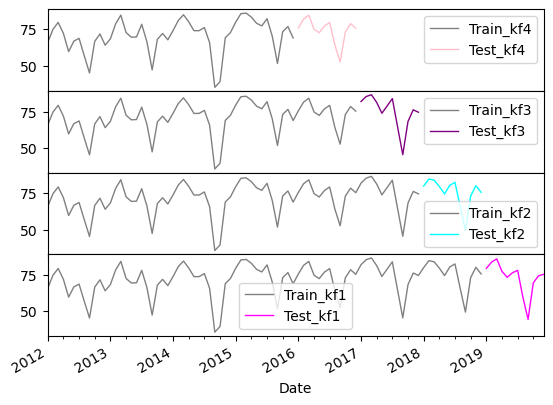

In [31]:
#Plot train and test data

# to set the plot size
plt.figure(figsize=(20, 12), dpi=150)
fig, axs = plt.subplots(4, 1, sharex=True)
fig.subplots_adjust(hspace=0)
  
# using plot method to plot close prices.
# in plot method we set the label and color of the curve.
kfold_train_data_list[3].plot(label='Train_kf4', linewidth=1, alpha=1, c='gray', ax=axs[0])
kfold_train_data_list[2].plot(label='Train_kf3', linewidth=1, alpha=1, c='gray', ax=axs[1])
kfold_train_data_list[1].plot(label='Train_kf2', linewidth=1, alpha=1, c='gray', ax=axs[2])
kfold_train_data_list[0].plot(label='Train_kf1', linewidth=1, alpha=1, c='gray', ax=axs[3])
kfold_test_data_list[3].plot(label='Test_kf4', linewidth=1, alpha=1, c='pink', ax=axs[0])
kfold_test_data_list[2].plot(label='Test_kf3', linewidth=1, alpha=1, c='purple', ax=axs[1])
kfold_test_data_list[1].plot(label='Test_kf2', linewidth=1, alpha=1, c='cyan', ax=axs[2])
kfold_test_data_list[0].plot(label='Test_kf1', linewidth=1, alpha=1, c='magenta', ax=axs[3])
  
# adding Label to the x-axis
plt.xlabel('Date')
fig.autofmt_xdate()
  
# adding legend to the curve
axs[0].legend()
axs[1].legend()
axs[2].legend()
axs[3].legend()

## 9. Hotel Occupancy Backtesting (Long Term - 12 Months)

In [32]:
def mod_metrics_cal(actuals, predictions, train):
    me = np.mean(actuals - predictions)
    mse = mean_squared_error(actuals, predictions)
    rmse = sqrt(mse)
    mae = mean_absolute_error(actuals, predictions)
    mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100
    naive_mae = np.mean(np.absolute(np.diff(np.trim_zeros(train))))
    naive_mse = np.mean((np.diff(np.trim_zeros(train))**2))
    mase = mae / naive_mae
    rmsse = np.sqrt(mse/naive_mse)
    
    return np.array([me, rmse, mae, mape, mase, rmsse])

In [33]:
kfold_number = 4

arima_nonseasonal_metrics = np.zeros((kfold_number, 6))
arima_seasonal_metrics = np.zeros((kfold_number, 6))
simple_ets_metrics = np.zeros((kfold_number, 6))
double_ets_add_metrics = np.zeros((kfold_number, 6))
double_ets_mul_metrics = np.zeros((kfold_number, 6))
triple_ets_add_metrics = np.zeros((kfold_number, 6))
triple_ets_mul_metrics = np.zeros((kfold_number, 6))
best_avg_metrics = np.zeros((kfold_number, 6))

for kfold in range(kfold_number):
    mae_list = []
    pred_values_list = []
    # Non Seasonal ARIMA Model
    auto_nonseasonal_model = pm.auto_arima(kfold_train_data_list[kfold], start_p=0, start_q=0, 
                                           test='adf',       # use adftest to find optimal 'd'
                                           max_p=3, max_q=3, # maximum p and q
                                           m=12,              # frequency of series
                                           d=None,           # let model determine 'd'
                                           seasonal=False,   # No Seasonality
                                           trace=True,
                                           error_action='ignore',  
                                           suppress_warnings=True, 
                                           stepwise=True)
    fc_auto_non_seasonal, confint = auto_nonseasonal_model.predict(n_periods=12, return_conf_int=True)
    arima_nonseasonal_metrics[kfold] = mod_metrics_cal(kfold_test_data_list[kfold].values.flatten(), 
                                                       fc_auto_non_seasonal.values.flatten(),
                                                       kfold_train_data_list[kfold].values.flatten())
    mae_list.append(arima_nonseasonal_metrics[kfold, 2])
    pred_values_list.append(fc_auto_non_seasonal)
    
    # Seasonal ARIMA Model
    auto_seasonal_model = pm.auto_arima(kfold_train_data_list[kfold], start_p=0, start_q=0,
                                        test='adf',
                                        max_p=3, max_q=3, m=12,
                                        start_P=0, seasonal=True,
                                        d=None, D=1, trace=True,
                                        error_action='ignore',  
                                        suppress_warnings=True, 
                                        stepwise=True)
    fc_auto_seasonal, confint = auto_seasonal_model.predict(n_periods=12, return_conf_int=True)
    arima_seasonal_metrics[kfold] = mod_metrics_cal(kfold_test_data_list[kfold].values.flatten(), 
                                                    fc_auto_seasonal.values.flatten(),
                                                    kfold_train_data_list[kfold].values.flatten())
    mae_list.append(arima_seasonal_metrics[kfold, 2])
    pred_values_list.append(fc_auto_seasonal)
    
    # simple ets Optimized Alpha (0.306)
    simple_ets_opt = SimpleExpSmoothing(kfold_train_data_list[kfold]).fit()
    simple_ets_opt_pred = simple_ets_opt.forecast(12).rename('alpha_optimized')
    simple_ets_metrics[kfold] = mod_metrics_cal(kfold_test_data_list[kfold].values.flatten(), 
                                                simple_ets_opt_pred.values.flatten(),
                                                kfold_train_data_list[kfold].values.flatten())
    mae_list.append(simple_ets_metrics[kfold, 2])
    pred_values_list.append(simple_ets_opt_pred)
    
    # Double ETS
    double_ets_add = ExponentialSmoothing(kfold_train_data_list[kfold], trend = 'add').fit()
    double_ets_mul = ExponentialSmoothing(kfold_train_data_list[kfold], trend = 'mul').fit()
    double_ets_add_pred = double_ets_add.forecast(12)
    double_ets_mul_pred = double_ets_mul.forecast(12)
    
    double_ets_add_metrics[kfold] = mod_metrics_cal(kfold_test_data_list[kfold].values.flatten(), 
                                                    double_ets_add_pred.values.flatten(),
                                                    kfold_train_data_list[kfold].values.flatten())
    double_ets_mul_metrics[kfold] = mod_metrics_cal(kfold_test_data_list[kfold].values.flatten(), 
                                                    double_ets_mul_pred.values.flatten(),
                                                    kfold_train_data_list[kfold].values.flatten())
    mae_list.append(double_ets_add_metrics[kfold, 2])
    pred_values_list.append(double_ets_add_pred)
    mae_list.append(double_ets_mul_metrics[kfold, 2])
    pred_values_list.append(double_ets_mul_pred)
    
    # Triple ETS
    triple_ets_add = ExponentialSmoothing(kfold_train_data_list[kfold], trend = 'add', 
                                      seasonal = 'add', seasonal_periods=12).fit()
    triple_ets_mul = ExponentialSmoothing(kfold_train_data_list[kfold], trend = 'mul', 
                                      seasonal = 'mul', seasonal_periods=12).fit()
    triple_ets_add_pred = triple_ets_add.forecast(12)
    triple_ets_mul_pred = triple_ets_mul.forecast(12)
    triple_ets_add_metrics[kfold] = mod_metrics_cal(kfold_test_data_list[kfold].values.flatten(), 
                                                    triple_ets_add_pred.values.flatten(),
                                                    kfold_train_data_list[kfold].values.flatten())
    triple_ets_mul_metrics[kfold] = mod_metrics_cal(kfold_test_data_list[kfold].values.flatten(), 
                                                    triple_ets_mul_pred.values.flatten(),
                                                    kfold_train_data_list[kfold].values.flatten())
    mae_list.append(triple_ets_add_metrics[kfold, 2])
    pred_values_list.append(triple_ets_add_pred)
    mae_list.append(triple_ets_mul_metrics[kfold, 2])
    pred_values_list.append(triple_ets_mul_pred)
    
    # Adaptative Average of best 3 models
    best_model_idx = np.argsort(np.array(mae_list))
    best_avg_pred = (pred_values_list[best_model_idx[0]] + pred_values_list[best_model_idx[1]] +
                 pred_values_list[best_model_idx[2]]) / 3
    best_avg_metrics[kfold] = mod_metrics_cal(kfold_test_data_list[kfold].values.flatten(), 
                                              best_avg_pred.values.flatten(),
                                              kfold_train_data_list[kfold].values.flatten())
    

C:\Users\julio\anaconda3\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=961.172, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=644.503, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=646.453, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=643.168, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=634.265, Time=0.05 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=620.179, Time=0.08 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=609.020, Time=0.14 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=607.346, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=605.766, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=786.849, Time=0.05 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=607.270, Time=0.10 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.15 se

C:\Users\julio\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\julio\anaconda3\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=823.010, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=554.079, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=556.031, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=553.307, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=543.018, Time=0.05 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=535.036, Time=0.07 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=523.397, Time=0.12 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=521.412, Time=0.10 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=519.616, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=708.015, Time=0.08 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=521.405, Time=0.12 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.12 se

C:\Users\julio\anaconda3\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=684.995, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=461.933, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=463.893, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=462.106, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=453.200, Time=0.05 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=448.188, Time=0.07 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=436.174, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=434.301, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=556.726, Time=0.06 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=436.176, Time=0.11 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 A

C:\Users\julio\anaconda3\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=547.461, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=373.900, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=375.854, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=374.594, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=368.670, Time=0.04 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=365.273, Time=0.04 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=350.866, Time=0.13 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=348.867, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=346.878, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=344.916, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=371.961, Time=0.01 se

<Figure size 3000x1800 with 0 Axes>

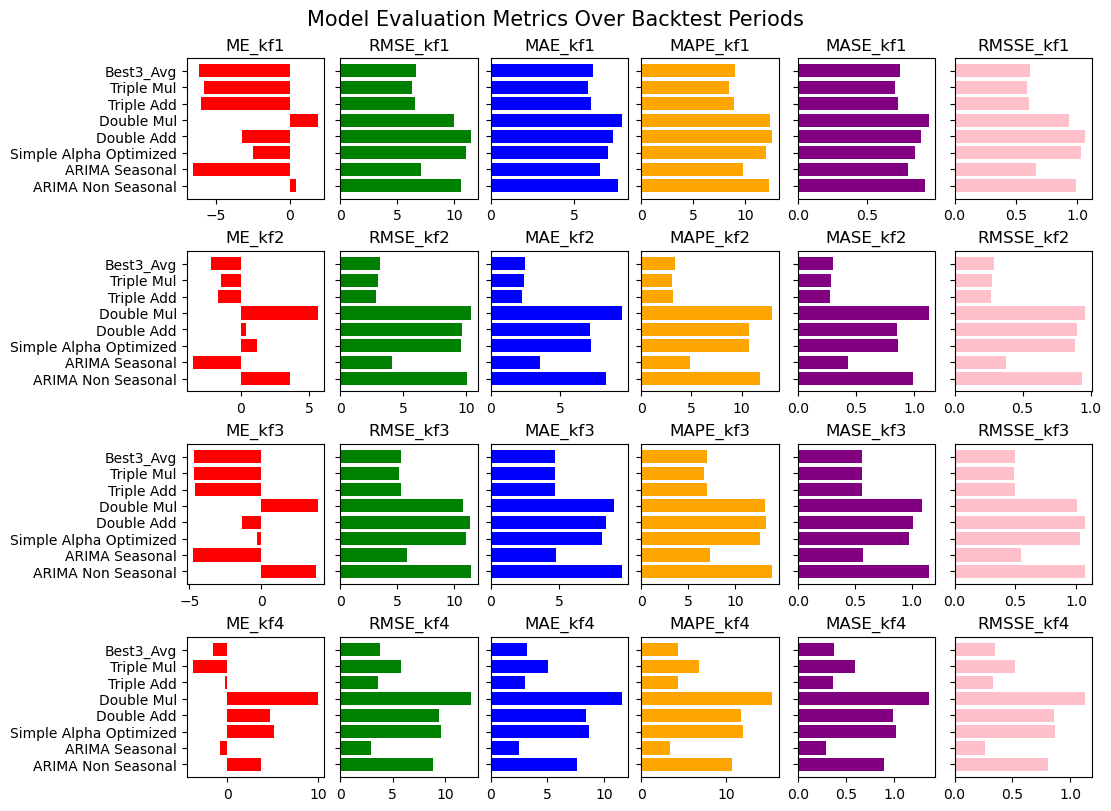

In [34]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [11, 8]
plt.rcParams['figure.dpi'] = 100

kfold_number = 4

plt.figure(figsize=(20, 12), dpi=150)
fig, axs = plt.subplots(4, 6, sharey=True, constrained_layout = True)
#fig.subplots_adjust(hspace=0)

for kf in range(kfold_number):
    metrics_kf = np.stack((arima_nonseasonal_metrics[kf], arima_seasonal_metrics[kf],
                           simple_ets_metrics[kf], double_ets_add_metrics[kf], 
                           double_ets_mul_metrics[kf], triple_ets_add_metrics[kf], 
                           triple_ets_mul_metrics[kf], best_avg_metrics[kf]))
    metrics_kf_df = pd.DataFrame(metrics_kf, 
                                 columns=['ME', 'RMSE', 'MAE', 'MAPE', 'MASE', 'RMSSE'],
                                 index=['ARIMA Non Seasonal', 'ARIMA Seasonal', 'Simple Alpha Optimized',
                                         'Double Add', 'Double Mul', 'Triple Add', 'Triple Mul', 'Best3_Avg'])

    me_df = metrics_kf_df[['ME']]
    rmse_df = metrics_kf_df[['RMSE']]
    mae_df = metrics_kf_df[['MAE']]
    mape_df = metrics_kf_df[['MAPE']]
    mase_df = metrics_kf_df[['MASE']]
    rmsse = metrics_kf_df[['RMSSE']]

    axs[kf,0].barh(metrics_kf_df.index ,metrics_kf_df['ME'], color='red')
    axs[kf,0].set_title(f'ME_kf{kf + 1}')
    axs[kf,1].barh(metrics_kf_df.index ,metrics_kf_df['RMSE'], color='green')
    axs[kf,1].set_title(f'RMSE_kf{kf + 1}')
    axs[kf,2].barh(metrics_kf_df.index ,metrics_kf_df['MAE'], color='blue')
    axs[kf,2].set_title(f'MAE_kf{kf + 1}')
    axs[kf,3].barh(metrics_kf_df.index ,metrics_kf_df['MAPE'], color='orange')
    axs[kf,3].set_title(f'MAPE_kf{kf + 1}')
    axs[kf,4].barh(metrics_kf_df.index ,metrics_kf_df['MASE'], color='purple')
    axs[kf,4].set_title(f'MASE_kf{kf + 1}')
    axs[kf,5].barh(metrics_kf_df.index ,metrics_kf_df['RMSSE'], color='pink')
    axs[kf,5].set_title(f'RMSSE_kf{kf + 1}')

plt.suptitle('Model Evaluation Metrics Over Backtest Periods', fontsize=15)
plt.show()

In [35]:
arima_nonseasonal_mean_metrics = np.mean(arima_nonseasonal_metrics, axis=0)
arima_seasonal_mean_metrics = np.mean(arima_seasonal_metrics, axis=0)
simple_ets_mean_metrics = np.mean(simple_ets_metrics, axis=0)
double_ets_add_mean_metrics = np.mean(double_ets_add_metrics, axis=0)
double_ets_mul_mean_metrics = np.mean(double_ets_mul_metrics, axis=0)
triple_ets_add_mean_metrics = np.mean(triple_ets_add_metrics, axis=0)
triple_ets_mul_mean_metrics = np.mean(triple_ets_mul_metrics, axis=0)
best_avg_mean_metrics = np.mean(best_avg_metrics, axis=0)

mean_backtest_metrics = np.stack((arima_nonseasonal_mean_metrics, arima_seasonal_mean_metrics,
                                  simple_ets_mean_metrics, double_ets_add_mean_metrics, 
                                  double_ets_mul_mean_metrics, triple_ets_add_mean_metrics, 
                                  triple_ets_mul_mean_metrics, best_avg_mean_metrics))

mean_backtest_metrics_df = pd.DataFrame(mean_backtest_metrics, 
                                        columns=['ME', 'RMSE', 'MAE', 'MAPE', 'MASE', 'RMSSE'],
                                        index=['ARIMA Non Seasonal', 'ARIMA Seasonal', 'Simple Alpha Optimized',
                                               'Double Add', 'Double Mul', 'Triple Add', 'Triple Mul', 'Best3_Avg'])

In [36]:
mean_backtest_metrics_df.sort_values(by='MAE')

,ME,RMSE,MAE,MAPE,MASE,RMSSE
Triple Add,-3.122706,4.603765,4.004939,5.823097,0.479833,0.426996
Best3_Avg,-3.659901,4.726991,4.122528,5.935317,0.493870,0.438352
ARIMA Seasonal,-3.918145,4.998976,4.345922,6.340934,0.520975,0.464180
Triple Mul,-3.938852,5.069030,4.478432,6.246098,0.535565,0.469038
Simple Alpha Optimized,0.903330,10.305556,7.738333,11.848426,0.924976,0.954600
Double Add,0.141194,10.496268,7.811738,12.068639,0.933988,0.972485
ARIMA Non Seasonal,2.889215,10.270116,8.263839,12.189049,0.988793,0.951724
Double Mul,5.358721,10.903258,9.452642,13.482548,1.129100,1.008445


## Best Model Compared with Actual Occupancy

In [37]:
kfold_number = 4

forecast_list = []

for kfold in range(kfold_number):
    
    # Triple ETS
    triple_ets_add = ExponentialSmoothing(kfold_train_data_list[kfold], trend = 'add', 
                                      seasonal = 'add', seasonal_periods=12).fit()

    triple_ets_add_pred = triple_ets_add.forecast(12)
    forecast_list.append(triple_ets_add_pred)

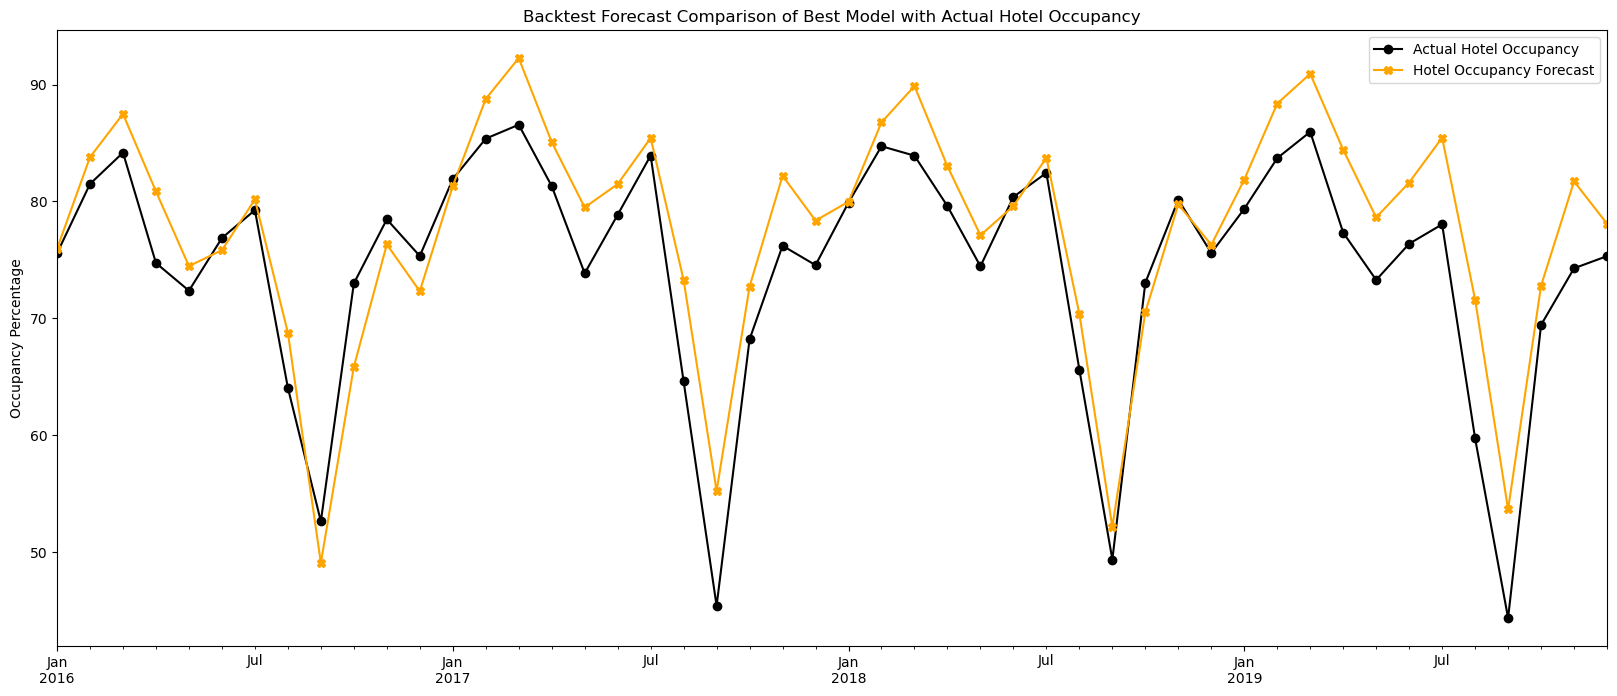

In [38]:
#plot the train, test, and predictions

#After creating model we will visualize the plot
ax = lc_occupancy_df['Total_Occupancy_Percentage'][datetime(2016, 1, 1):].plot(marker='o', color='black', 
                                                                               figsize=(20,8), legend=True,
                                                                               label='Actual Hotel Occupancy')
backtest_forecast = pd.concat([forecast_list[3], forecast_list[2], forecast_list[1], forecast_list[0]])

#Plot for triple ETS additive
backtest_forecast.plot(marker='X', ax=ax, color='orange', legend=True, label = 'Hotel Occupancy Forecast')

plt.title('Backtest Forecast Comparison of Best Model with Actual Hotel Occupancy')
#plt.xlabel('Date')
plt.ylabel('Occupancy Percentage')
plt.show()

## 10. Hotel Occupancy Backtesting (Short Term - 2 Months)

In [39]:
kfold_train_data_list = []
kfold_test_data_list = []
kfold_number = 4
period = 2

for kfold in range(kfold_number):
    if len(kfold_test_data_list) > 0:
        end_date = kfold_test_data_list[kfold - 1].index[0] - timedelta(days=1)
    else:
        end_date = lc_occupancy_df['Total_Occupancy_Percentage'].index[-1]
    
    train_data, test_data = train_test_split(lc_occupancy_df['Total_Occupancy_Percentage'][:end_date], 
                                             test_size=period, random_state=25, shuffle = False)
    #shuffle = False is very important to ensure the order of the data
    
    kfold_train_data_list.append(train_data)
    kfold_test_data_list.append(test_data)
    
    print(f"K Fold {kfold + 1}")
    print(f"No. of training examples: {train_data.shape[0]}")
    print(f"No. of testing examples: {test_data.shape[0]}")

K Fold 1
No. of training examples: 94
No. of testing examples: 2
K Fold 2
No. of training examples: 92
No. of testing examples: 2
K Fold 3
No. of training examples: 90
No. of testing examples: 2
K Fold 4
No. of training examples: 88
No. of testing examples: 2


<Figure size 3000x1800 with 0 Axes>

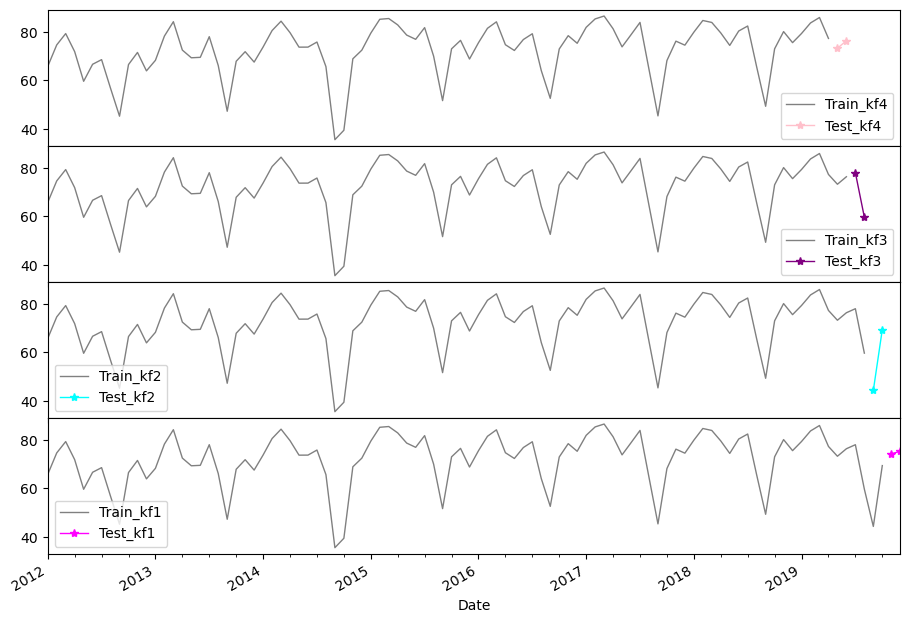

In [40]:
#Plot train and test data

# to set the plot size
plt.figure(figsize=(20, 12), dpi=150)
fig, axs = plt.subplots(4, 1, sharex=True)
fig.subplots_adjust(hspace=0)
  
# using plot method to plot close prices.
# in plot method we set the label and color of the curve.
kfold_train_data_list[3].plot(label='Train_kf4', linewidth=1, alpha=1, c='gray', ax=axs[0])
kfold_train_data_list[2].plot(label='Train_kf3', linewidth=1, alpha=1, c='gray', ax=axs[1])
kfold_train_data_list[1].plot(label='Train_kf2', linewidth=1, alpha=1, c='gray', ax=axs[2])
kfold_train_data_list[0].plot(label='Train_kf1', linewidth=1, alpha=1, c='gray', ax=axs[3])
kfold_test_data_list[3].plot(label='Test_kf4', linewidth=1, alpha=1, c='pink', ax=axs[0], marker='*')
kfold_test_data_list[2].plot(label='Test_kf3', linewidth=1, alpha=1, c='purple', ax=axs[1], marker='*')
kfold_test_data_list[1].plot(label='Test_kf2', linewidth=1, alpha=1, c='cyan', ax=axs[2], marker='*')
kfold_test_data_list[0].plot(label='Test_kf1', linewidth=1, alpha=1, c='magenta', ax=axs[3], marker='*')
  
# adding Label to the x-axis
plt.xlabel('Date')
fig.autofmt_xdate()
  
# adding legend to the curve
axs[0].legend()
axs[1].legend()
axs[2].legend()
axs[3].legend()

In [41]:
def mod_metrics_cal(actuals, predictions, train):
    me = np.mean(actuals - predictions)
    mse = mean_squared_error(actuals, predictions)
    rmse = sqrt(mse)
    mae = mean_absolute_error(actuals, predictions)
    mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100
    naive_mae = np.mean(np.absolute(np.diff(np.trim_zeros(train))))
    naive_mse = np.mean((np.diff(np.trim_zeros(train))**2))
    mase = mae / naive_mae
    rmsse = np.sqrt(mse/naive_mse)
    
    return np.array([me, rmse, mae, mape, mase, rmsse])

In [42]:
kfold_number = 4

arima_nonseasonal_metrics = np.zeros((kfold_number, 6))
arima_seasonal_metrics = np.zeros((kfold_number, 6))
simple_ets_metrics = np.zeros((kfold_number, 6))
double_ets_add_metrics = np.zeros((kfold_number, 6))
double_ets_mul_metrics = np.zeros((kfold_number, 6))
triple_ets_add_metrics = np.zeros((kfold_number, 6))
triple_ets_mul_metrics = np.zeros((kfold_number, 6))

for kfold in range(kfold_number):
    mae_list = []
    pred_values_list = []
    # Non Seasonal ARIMA Model
    auto_nonseasonal_model = pm.auto_arima(kfold_train_data_list[kfold], start_p=0, start_q=0, 
                                           test='adf',       # use adftest to find optimal 'd'
                                           max_p=3, max_q=3, # maximum p and q
                                           m=12,              # frequency of series
                                           d=None,           # let model determine 'd'
                                           seasonal=False,   # No Seasonality
                                           trace=True,
                                           error_action='ignore',  
                                           suppress_warnings=True, 
                                           stepwise=True)
    fc_auto_non_seasonal, confint = auto_nonseasonal_model.predict(n_periods=2, return_conf_int=True)
    arima_nonseasonal_metrics[kfold] = mod_metrics_cal(kfold_test_data_list[kfold].values.flatten(), 
                                                       fc_auto_non_seasonal.values.flatten(),
                                                       kfold_train_data_list[kfold].values.flatten())
    mae_list.append(arima_nonseasonal_metrics[kfold, 2])
    pred_values_list.append(fc_auto_non_seasonal)
    
    # Seasonal ARIMA Model
    auto_seasonal_model = pm.auto_arima(kfold_train_data_list[kfold], start_p=0, start_q=0,
                                        test='adf',
                                        max_p=3, max_q=3, m=12,
                                        start_P=0, seasonal=True,
                                        d=None, D=1, trace=True,
                                        error_action='ignore',  
                                        suppress_warnings=True, 
                                        stepwise=True)
    fc_auto_seasonal, confint = auto_seasonal_model.predict(n_periods=2, return_conf_int=True)
    arima_seasonal_metrics[kfold] = mod_metrics_cal(kfold_test_data_list[kfold].values.flatten(), 
                                                    fc_auto_seasonal.values.flatten(),
                                                    kfold_train_data_list[kfold].values.flatten())
    mae_list.append(arima_seasonal_metrics[kfold, 2])
    pred_values_list.append(fc_auto_seasonal)
    
    # simple ets Optimized Alpha (0.306)
    simple_ets_opt = SimpleExpSmoothing(kfold_train_data_list[kfold]).fit()
    simple_ets_opt_pred = simple_ets_opt.forecast(2).rename('alpha_optimized')
    simple_ets_metrics[kfold] = mod_metrics_cal(kfold_test_data_list[kfold].values.flatten(), 
                                                simple_ets_opt_pred.values.flatten(),
                                                kfold_train_data_list[kfold].values.flatten())
    mae_list.append(simple_ets_metrics[kfold, 2])
    pred_values_list.append(simple_ets_opt_pred)
    
    # Double ETS
    double_ets_add = ExponentialSmoothing(kfold_train_data_list[kfold], trend = 'add').fit()
    double_ets_mul = ExponentialSmoothing(kfold_train_data_list[kfold], trend = 'mul').fit()
    double_ets_add_pred = double_ets_add.forecast(2)
    double_ets_mul_pred = double_ets_mul.forecast(2)
    
    double_ets_add_metrics[kfold] = mod_metrics_cal(kfold_test_data_list[kfold].values.flatten(), 
                                                    double_ets_add_pred.values.flatten(),
                                                    kfold_train_data_list[kfold].values.flatten())
    double_ets_mul_metrics[kfold] = mod_metrics_cal(kfold_test_data_list[kfold].values.flatten(), 
                                                    double_ets_mul_pred.values.flatten(),
                                                    kfold_train_data_list[kfold].values.flatten())
    mae_list.append(double_ets_add_metrics[kfold, 2])
    pred_values_list.append(double_ets_add_pred)
    mae_list.append(double_ets_mul_metrics[kfold, 2])
    pred_values_list.append(double_ets_mul_pred)
    
    # Triple ETS
    triple_ets_add = ExponentialSmoothing(kfold_train_data_list[kfold], trend = 'add', 
                                      seasonal = 'add', seasonal_periods=12).fit()
    triple_ets_mul = ExponentialSmoothing(kfold_train_data_list[kfold], trend = 'mul', 
                                      seasonal = 'mul', seasonal_periods=12).fit()
    triple_ets_add_pred = triple_ets_add.forecast(2)
    triple_ets_mul_pred = triple_ets_mul.forecast(2)
    triple_ets_add_metrics[kfold] = mod_metrics_cal(kfold_test_data_list[kfold].values.flatten(), 
                                                    triple_ets_add_pred.values.flatten(),
                                                    kfold_train_data_list[kfold].values.flatten())
    triple_ets_mul_metrics[kfold] = mod_metrics_cal(kfold_test_data_list[kfold].values.flatten(), 
                                                    triple_ets_mul_pred.values.flatten(),
                                                    kfold_train_data_list[kfold].values.flatten())
    mae_list.append(triple_ets_add_metrics[kfold, 2])
    pred_values_list.append(triple_ets_add_pred)
    mae_list.append(triple_ets_mul_metrics[kfold, 2])
    pred_values_list.append(triple_ets_mul_pred)
    
    # Adaptative Average of best 3 models
    best_model_idx = np.argsort(np.array(mae_list))
    best_avg_pred = (pred_values_list[best_model_idx[0]] + pred_values_list[best_model_idx[1]] +
                 pred_values_list[best_model_idx[2]]) / 3
    best_avg_metrics[kfold] = mod_metrics_cal(kfold_test_data_list[kfold].values.flatten(), 
                                              best_avg_pred.values.flatten(),
                                              kfold_train_data_list[kfold].values.flatten())

C:\Users\julio\anaconda3\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1075.554, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=721.850, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=723.842, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=719.816, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=710.061, Time=0.05 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=692.169, Time=0.07 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=679.738, Time=0.16 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=678.503, Time=0.12 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=677.186, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=879.669, Time=0.07 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=678.325, Time=0.12 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.15 s

C:\Users\julio\anaconda3\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1053.438, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=701.010, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=702.961, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=699.177, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=689.436, Time=0.05 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=674.318, Time=0.06 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=662.860, Time=0.16 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=661.140, Time=0.11 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=659.597, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=860.344, Time=0.08 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=661.067, Time=0.11 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=662.922, Time=0.

C:\Users\julio\anaconda3\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1030.787, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=685.096, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=917.346, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=687.043, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=683.346, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=673.686, Time=0.05 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=658.552, Time=0.07 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=646.542, Time=0.16 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=644.933, Time=0.11 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=643.519, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=843.200, Time=0.06 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=644.822, Time=0.12 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.

C:\Users\julio\anaconda3\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1007.848, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=671.794, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=673.747, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=670.193, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=660.733, Time=0.06 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=646.168, Time=0.07 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=634.521, Time=0.14 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=632.874, Time=0.11 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=631.430, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=632.774, Time=0.12 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 

<Figure size 3000x1800 with 0 Axes>

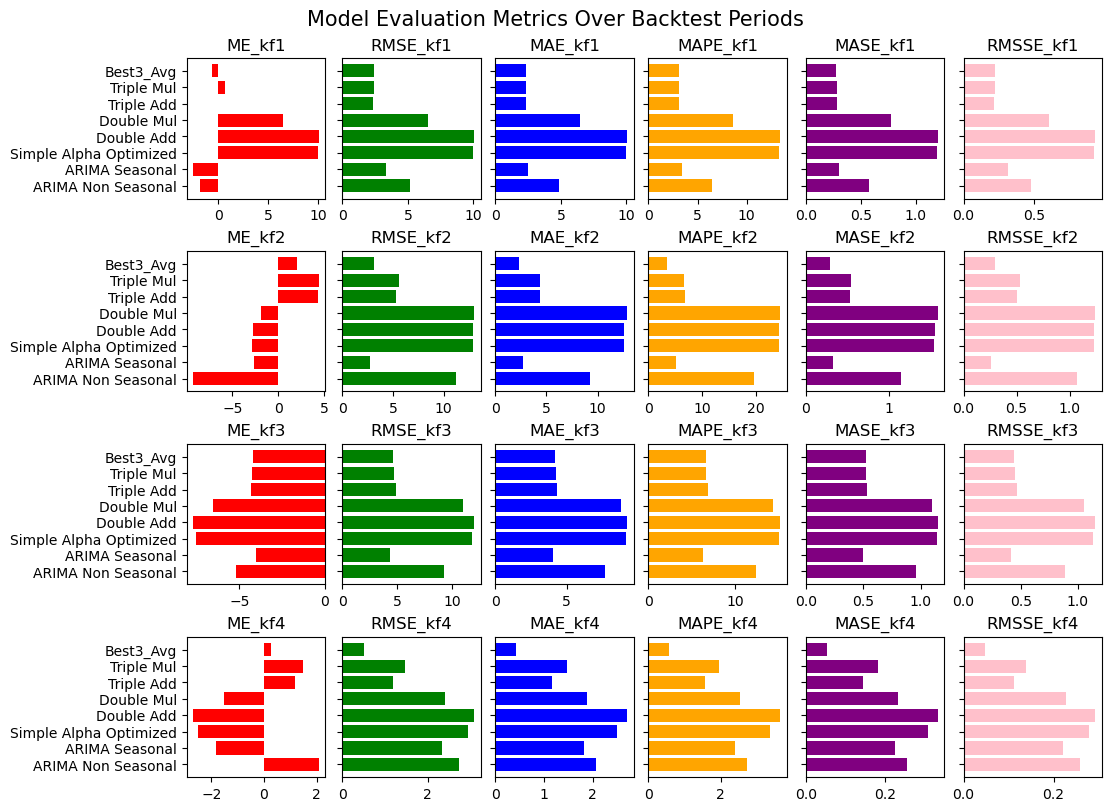

In [43]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [11, 8]
plt.rcParams['figure.dpi'] = 100

kfold_number = 4

plt.figure(figsize=(20, 12), dpi=150)
fig, axs = plt.subplots(4, 6, sharey=True, constrained_layout = True)
#fig.subplots_adjust(hspace=0)

for kf in range(kfold_number):
    metrics_kf = np.stack((arima_nonseasonal_metrics[kf], arima_seasonal_metrics[kf],
                           simple_ets_metrics[kf], double_ets_add_metrics[kf], 
                           double_ets_mul_metrics[kf], triple_ets_add_metrics[kf], 
                           triple_ets_mul_metrics[kf], best_avg_metrics[kf]))
    metrics_kf_df = pd.DataFrame(metrics_kf, 
                                 columns=['ME', 'RMSE', 'MAE', 'MAPE', 'MASE', 'RMSSE'],
                                 index=['ARIMA Non Seasonal', 'ARIMA Seasonal', 'Simple Alpha Optimized',
                                         'Double Add', 'Double Mul', 'Triple Add', 'Triple Mul', 'Best3_Avg'])

    me_df = metrics_kf_df[['ME']]
    rmse_df = metrics_kf_df[['RMSE']]
    mae_df = metrics_kf_df[['MAE']]
    mape_df = metrics_kf_df[['MAPE']]
    mase_df = metrics_kf_df[['MASE']]
    rmsse = metrics_kf_df[['RMSSE']]

    axs[kf,0].barh(metrics_kf_df.index ,metrics_kf_df['ME'], color='red')
    axs[kf,0].set_title(f'ME_kf{kf + 1}')
    axs[kf,1].barh(metrics_kf_df.index ,metrics_kf_df['RMSE'], color='green')
    axs[kf,1].set_title(f'RMSE_kf{kf + 1}')
    axs[kf,2].barh(metrics_kf_df.index ,metrics_kf_df['MAE'], color='blue')
    axs[kf,2].set_title(f'MAE_kf{kf + 1}')
    axs[kf,3].barh(metrics_kf_df.index ,metrics_kf_df['MAPE'], color='orange')
    axs[kf,3].set_title(f'MAPE_kf{kf + 1}')
    axs[kf,4].barh(metrics_kf_df.index ,metrics_kf_df['MASE'], color='purple')
    axs[kf,4].set_title(f'MASE_kf{kf + 1}')
    axs[kf,5].barh(metrics_kf_df.index ,metrics_kf_df['RMSSE'], color='pink')
    axs[kf,5].set_title(f'RMSSE_kf{kf + 1}')

plt.suptitle('Model Evaluation Metrics Over Backtest Periods', fontsize=15)
plt.show()

In [44]:
arima_nonseasonal_mean_metrics = np.mean(arima_nonseasonal_metrics, axis=0)
arima_seasonal_mean_metrics = np.mean(arima_seasonal_metrics, axis=0)
simple_ets_mean_metrics = np.mean(simple_ets_metrics, axis=0)
double_ets_add_mean_metrics = np.mean(double_ets_add_metrics, axis=0)
double_ets_mul_mean_metrics = np.mean(double_ets_mul_metrics, axis=0)
triple_ets_add_mean_metrics = np.mean(triple_ets_add_metrics, axis=0)
triple_ets_mul_mean_metrics = np.mean(triple_ets_mul_metrics, axis=0)
best_avg_mean_metrics = np.mean(best_avg_metrics, axis=0)

mean_backtest_metrics = np.stack((arima_nonseasonal_mean_metrics, arima_seasonal_mean_metrics,
                                  simple_ets_mean_metrics, double_ets_add_mean_metrics, 
                                  double_ets_mul_mean_metrics, triple_ets_add_mean_metrics, 
                                  triple_ets_mul_mean_metrics, best_avg_mean_metrics))

mean_backtest_metrics_df = pd.DataFrame(mean_backtest_metrics, 
                                        columns=['ME', 'RMSE', 'MAE', 'MAPE', 'MASE', 'RMSSE'],
                                        index=['ARIMA Non Seasonal', 'ARIMA Seasonal', 'Simple Alpha Optimized',
                                               'Double Add', 'Double Mul', 'Triple Add', 'Triple Mul', 'Best3_Avg'])

In [45]:
mean_backtest_metrics_df.sort_values(by='MAE')

,ME,RMSE,MAE,MAPE,MASE,RMSSE
Best3_Avg,-0.634164,2.651365,2.307123,3.424989,0.283320,0.251236
ARIMA Seasonal,-2.757852,3.197390,2.757852,4.305422,0.338427,0.302292
Triple Add,0.294392,3.405515,3.038680,4.576228,0.373493,0.323012
Triple Mul,0.560969,3.544319,3.105204,4.607755,0.381617,0.336101
ARIMA Non Seasonal,-3.546745,7.097529,5.968108,10.327743,0.733246,0.672851
Double Mul,-0.856787,8.230911,7.513126,12.519551,0.922736,0.780008
Simple Alpha Optimized,-0.717668,9.407574,8.544832,14.018022,1.046690,0.889588
Double Add,-0.768216,9.504620,8.637395,14.146252,1.058013,0.898778


### Conclusions: Hotel Occupancy Backtesting (Long Term - 12 Months and Short Term - 2 Months)

- **Long Term - 12 Months**: The model that performed the best for all accuracy metrics (ME, RMSE, MAE, MAPE, MASE and RMSSE), and across the different test periods, was the Triple Exponential Smoothing with Additive Trend and Seasonality.

- **Short Term - 2 Months**: The model that performed the best for all accuracy metrics (ME, RMSE, MAE, MAPE, MASE and RMSSE), and across the different test periods, was the Auto ARIMA Seasonal.


## 12. Flights Dataset Cleanup

In [42]:
flights_raw_df = pd.read_csv('airport_data.csv', usecols=['Year', 'Month', 'Airport', 'Country', 'Count'])
flights_raw_df

,Year,Month,Airport,Country,Count
0,2012,Enero,"Acapulco, Gro.",Alemania,1
1,2012,Enero,"Acapulco, Gro.",Alemania,1
2,2012,Enero,"Acapulco, Gro.",Australia,6
3,2012,Enero,"Acapulco, Gro.",Australia,1
4,2012,Enero,"Acapulco, Gro.",Austria,1
...,...,...,...,...,...
386476,2023,Abril,"Zihuatanejo, Gro.",Suiza,2
386477,2023,Abril,"Zihuatanejo, Gro.",Tailandia,1
386478,2023,Abril,"Zihuatanejo, Gro.",Ucrania,1
386479,2023,Abril,"Zihuatanejo, Gro.",Ucrania,1


In [43]:
countries_dict = { country: idx for idx, country in enumerate(set(flights_raw_df['Country'])) }
dates_dict = { date: idx for idx, date in enumerate(pd.date_range('2012-01-01', '2023-04-01', freq='MS'))}

In [44]:
flights_arr = np.zeros((len(countries_dict), len(dates_dict)))

In [45]:
month_dict = {'Enero': 1, 'Febrero': 2, 'Marzo': 3, 'Abril': 4, 'Mayo': 5, 'Junio': 6, 'Julio': 7, 'Agosto': 8,
              'Septiembre': 9, 'Octubre': 10, 'Noviembre': 11, 'Diciembre': 12}

for idx in range(len(flights_raw_df)):
    year = int(flights_raw_df.loc[idx, 'Year'])
    month = month_dict[flights_raw_df.loc[idx, 'Month']]
    airport = flights_raw_df.loc[idx, 'Airport']
    country = flights_raw_df.loc[idx, 'Country']
    count = flights_raw_df.loc[idx, 'Count']
    if airport == 'Los Cabos, B.C.S.':
        flights_arr[countries_dict[country], dates_dict[datetime(year, month, 1)]] += int(count.replace(',', ''))

In [46]:
most_freq_nationalities = [ list(countries_dict.keys())[idx] for idx in np.argsort(flights_arr.mean(axis=1))[::-1][:3] ]
most_freq_nationalities

['Estados Unidos', 'Canadá', 'Reino Unido']

In [47]:
most_freq_nationalities_idx = [ idx for idx in np.argsort(flights_arr.mean(axis=1))[::-1][:3] ]
most_freq_nationalities_idx

[145, 99, 195]

In [48]:
flights_df1 = pd.Series(flights_arr[most_freq_nationalities_idx[0]], 
                        index= pd.date_range('2012-01-01', '2023-04-01', freq='MS'))[:datetime(2019, 12, 1)]
flights_df1

2012-01-01     62606.0
2012-02-01     76133.0
2012-03-01     96224.0
2012-04-01     74862.0
2012-05-01     67238.0
                ...   
2019-08-01    106630.0
2019-09-01     70362.0
2019-10-01    110410.0
2019-11-01    130268.0
2019-12-01    150759.0
Freq: MS, Length: 96, dtype: float64

In [49]:
flights_df2 = pd.Series(flights_arr[most_freq_nationalities_idx[1]], 
                        index= pd.date_range('2012-01-01', '2023-04-01', freq='MS'))[:datetime(2019, 12, 1)]
flights_df2

2012-01-01    20870.0
2012-02-01    20415.0
2012-03-01    21705.0
2012-04-01    13619.0
2012-05-01     7857.0
               ...   
2019-08-01     6028.0
2019-09-01     4758.0
2019-10-01     9618.0
2019-11-01    23065.0
2019-12-01    26854.0
Freq: MS, Length: 96, dtype: float64

In [50]:
flights_df3 = pd.Series(flights_arr[most_freq_nationalities_idx[2]], 
                        index= pd.date_range('2012-01-01', '2023-04-01', freq='MS'))[:datetime(2019, 12, 1)]
flights_df3

2012-01-01     477.0
2012-02-01     589.0
2012-03-01     691.0
2012-04-01     619.0
2012-05-01     442.0
               ...  
2019-08-01     797.0
2019-09-01     393.0
2019-10-01     675.0
2019-11-01    1911.0
2019-12-01    1856.0
Freq: MS, Length: 96, dtype: float64

## Correlation between Hotel Occupancy and Foreign Visitors

In [51]:
# Convert data series to dataframe and rename the column
flights_df1_c = pd.DataFrame(flights_df1,columns = ["USA"])
flights_df2_c = pd.DataFrame(flights_df1,columns = ["Canada"])
flights_df3_c = pd.DataFrame(flights_df1,columns = ["UK"])

In [52]:
# Merge Data
merged_data = pd.merge(pd.merge(pd.merge(lc_occupancy_df["Total_Occupancy_Percentage"], flights_df1_c,left_index=True, right_index=True),
                  flights_df2_c,left_index=True, right_index=True),
         flights_df3_c,left_index=True, right_index=True)

In [53]:
np.corrcoef(merged_data["Total_Occupancy_Percentage"],merged_data['USA'])

array([[1.        , 0.74715904],
       [0.74715904, 1.        ]])

In [54]:
np.corrcoef(merged_data["Total_Occupancy_Percentage"],merged_data['Canada'])

array([[1.        , 0.74715904],
       [0.74715904, 1.        ]])

In [55]:
np.corrcoef(merged_data["Total_Occupancy_Percentage"],merged_data['UK'])

array([[1.        , 0.74715904],
       [0.74715904, 1.        ]])

In [56]:
# Remove the trend and sesaonality
differenced = merged_data.diff().diff(12)
differenced

,Total_Occupancy_Percentage,USA,Canada,UK
2012-01-01,NaN,NaN,NaN,NaN
2012-02-01,NaN,NaN,NaN,NaN
2012-03-01,NaN,NaN,NaN,NaN
2012-04-01,NaN,NaN,NaN,NaN
2012-05-01,NaN,NaN,NaN,NaN
...,...,...,...,...
2019-08-01,-1.48,6123.0,6123.0,6123.0
2019-09-01,0.88,3295.0,3295.0,3295.0
2019-10-01,1.40,5483.0,5483.0,5483.0
2019-11-01,-2.26,967.0,967.0,967.0


In [57]:
np.corrcoef(differenced['Total_Occupancy_Percentage'].dropna(),differenced['USA'].dropna())

array([[1.        , 0.78233968],
       [0.78233968, 1.        ]])

In [58]:
np.corrcoef(differenced['Total_Occupancy_Percentage'].dropna(),differenced['Canada'].dropna())

array([[1.        , 0.78233968],
       [0.78233968, 1.        ]])

In [59]:
np.corrcoef(differenced['Total_Occupancy_Percentage'].dropna(),differenced['UK'].dropna())

array([[1.        , 0.78233968],
       [0.78233968, 1.        ]])

Total Occupancy percentage is positively related with number of foreign visitors. 

## 13. Flights Dataset EDA

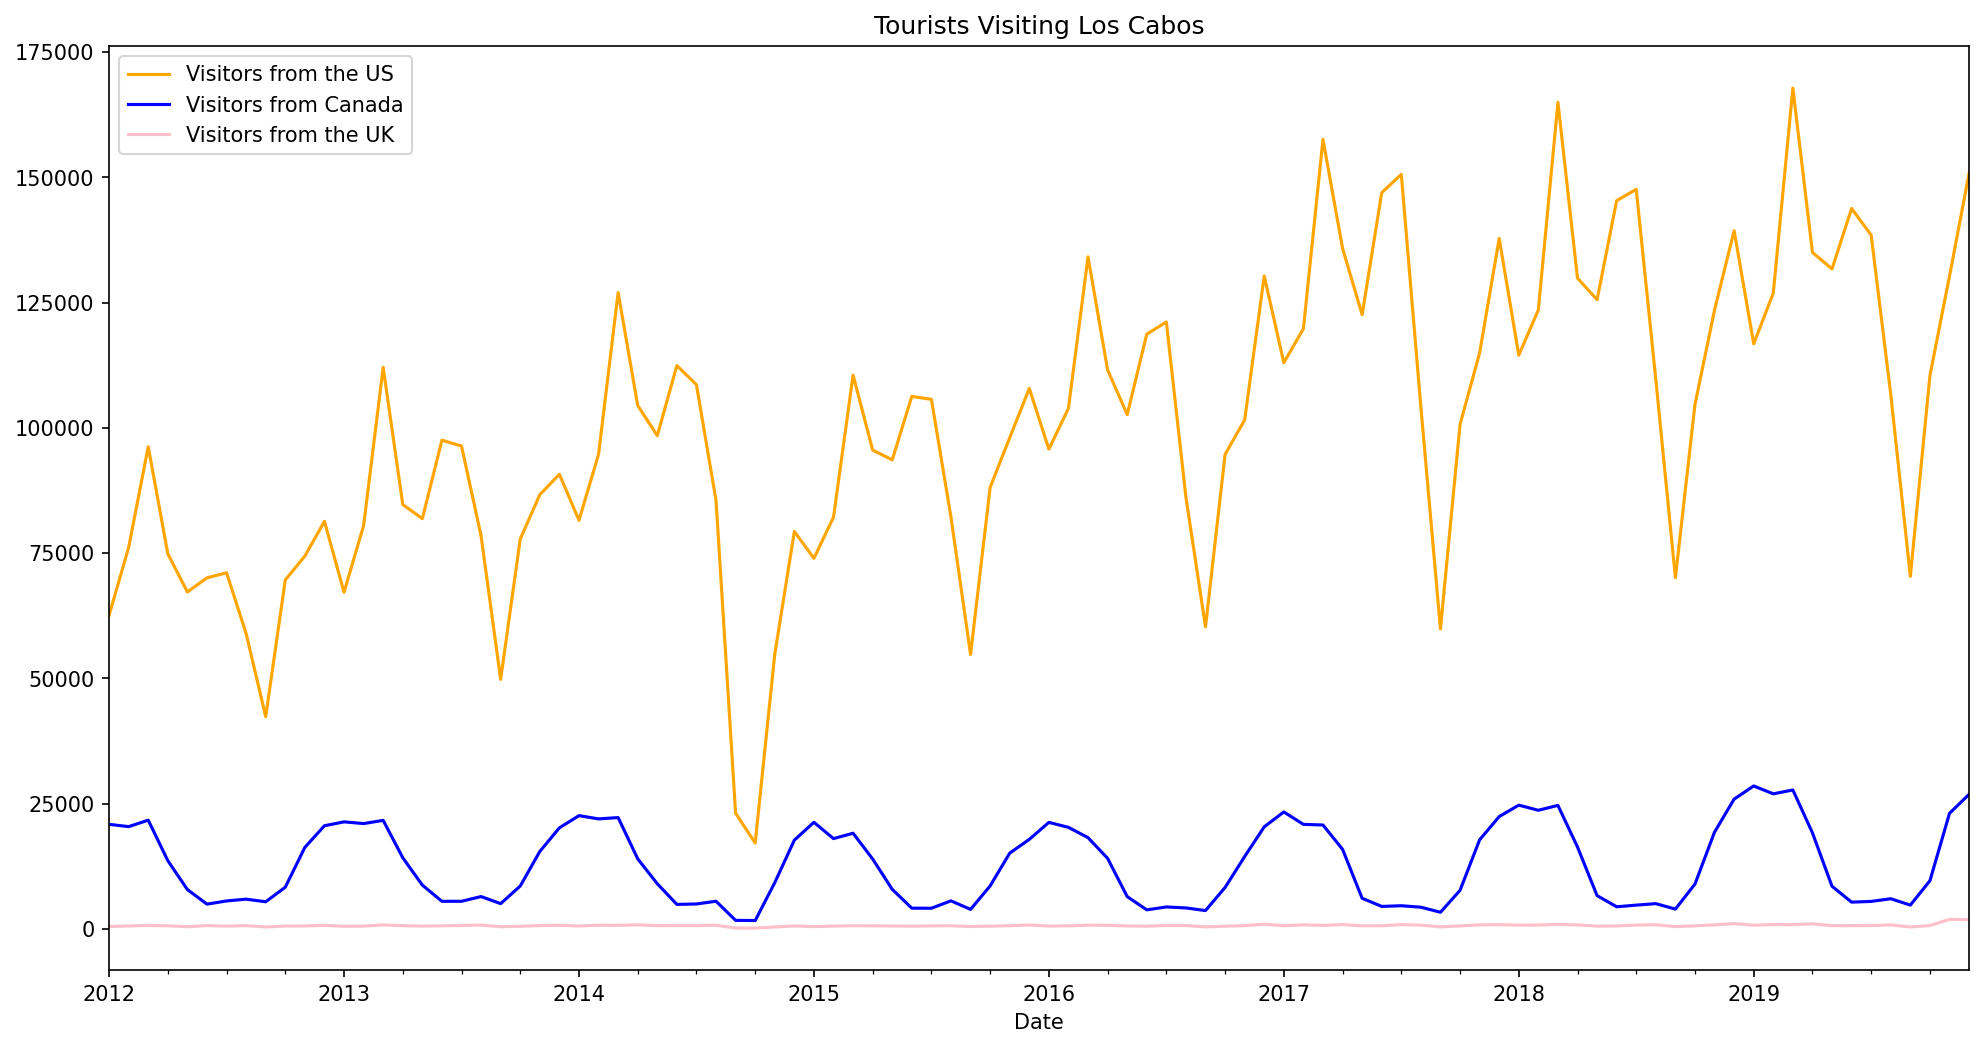

In [60]:
# Visualizing
  
# to set the plot size
plt.figure(figsize=(16, 8), dpi=150) #dpi = resolution. default 100.
  
# using plot method to plot close prices.
# in plot method we set the label and color of the curve.
flights_df1.plot(label='Visitors from the US', color='orange')
flights_df2.plot(label='Visitors from Canada', color='blue')
flights_df3.plot(label='Visitors from the UK', color='pink')
  
# adding title to the plot
plt.title('Tourists Visiting Los Cabos')
  
# adding Label to the x-axis
plt.xlabel('Date')
  
# adding legend to the curve
plt.legend()

<Axes: >

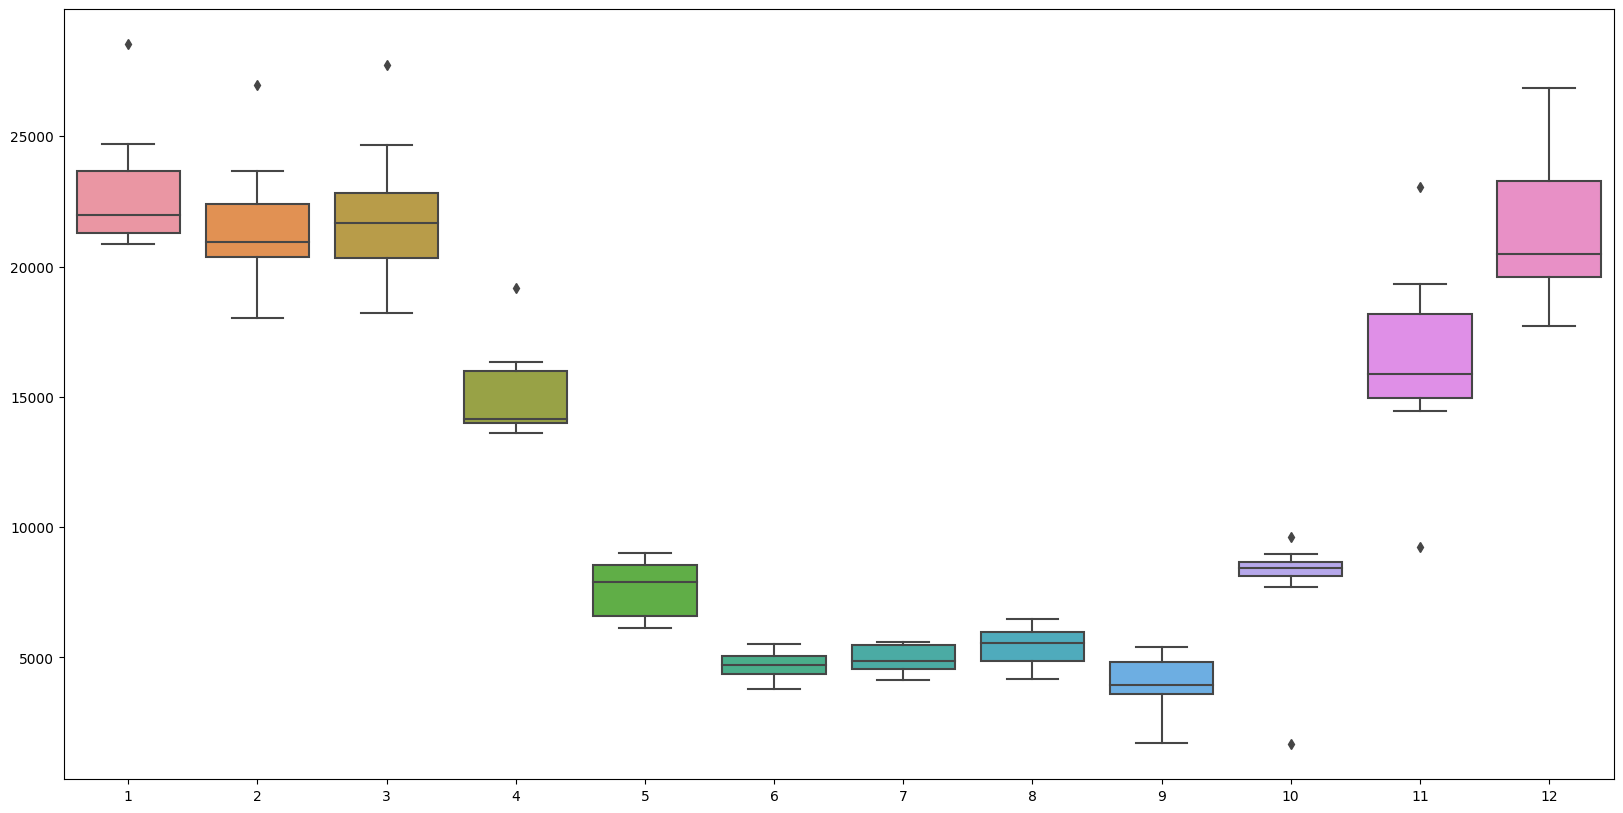

In [61]:
# Monthly Visitors from Canada

fig, ax = plt.subplots(figsize=(20,10))
sns.boxplot(x = flights_df2.index.month,
            y = flights_df2, 
            ax = ax)

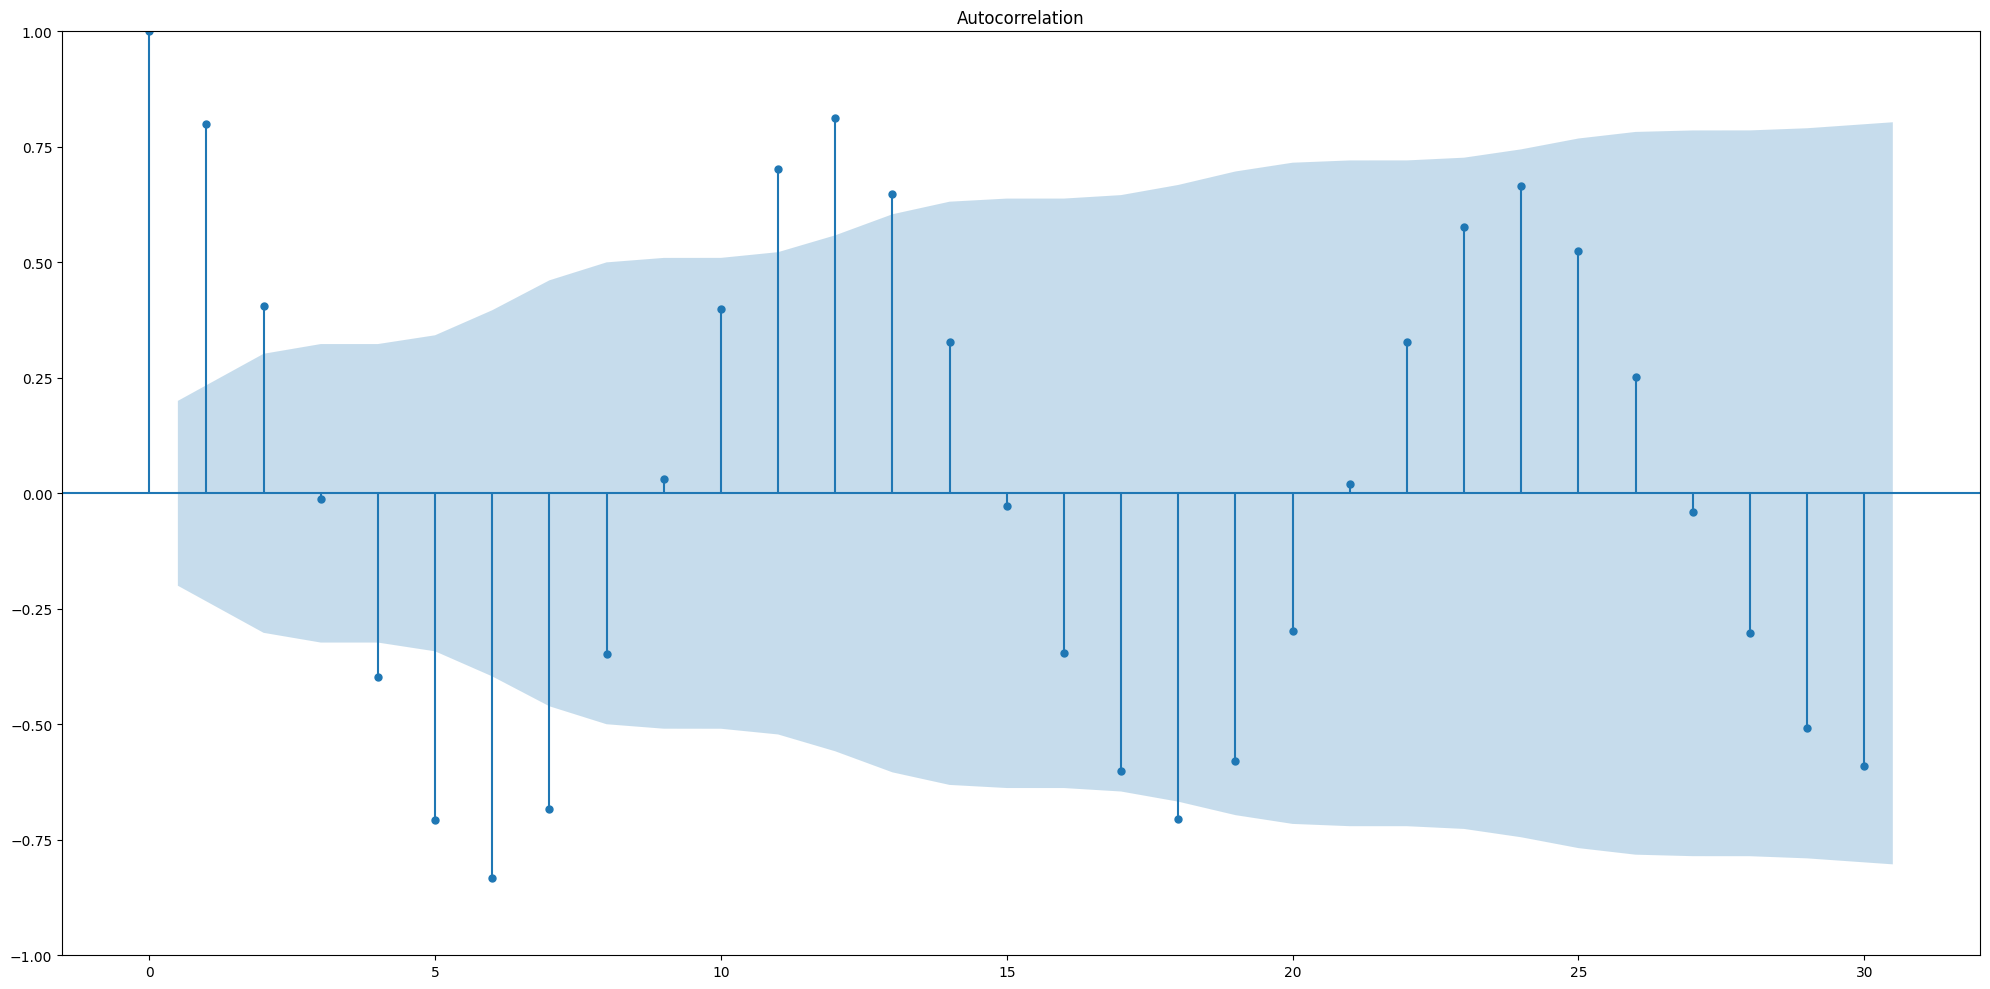

In [62]:
# Autocorrelation or ACF plot for Monthly Visitors from Canada

fig = plot_acf(flights_df2, lags=30)
fig.set_size_inches((20, 10))
# Tight layout to realign things
fig.tight_layout()
plt.show()

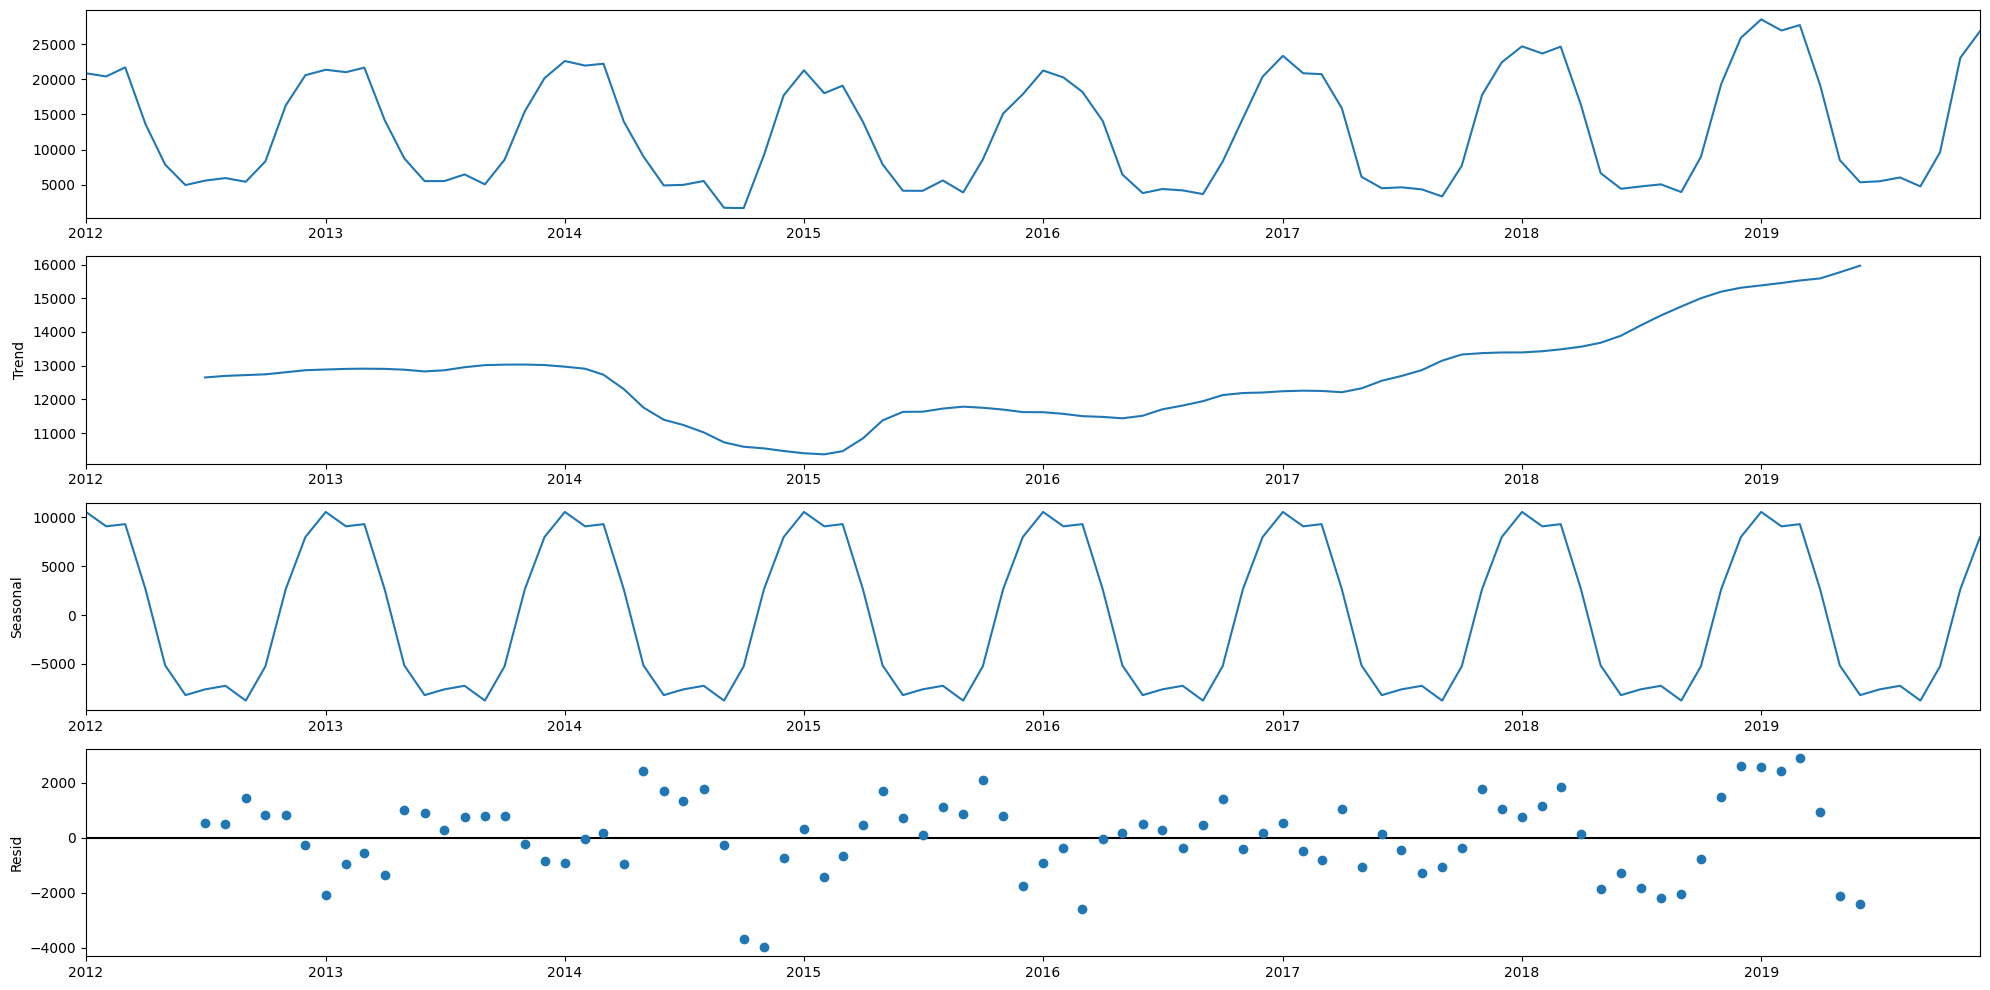

In [63]:
# Visitors from Canada - Time Series Decomposition

res = sm.tsa.seasonal_decompose(flights_df2, period=12)
fig = res.plot()
fig.set_size_inches((20, 10))
# Tight layout to realign things
fig.tight_layout()
plt.show()

## 14. Split Flights Data into Train and Test Sets

In [64]:
# Create a test set of 12 data points
test_size = 12

train_data, test_data = train_test_split(flights_df2, test_size=test_size, random_state=25, shuffle = False)
#shuffle = False is very important to ensure the order of the data

print(f"No. of training examples: {train_data.shape[0]}")
print(f"No. of testing examples: {test_data.shape[0]}")

No. of training examples: 84
No. of testing examples: 12


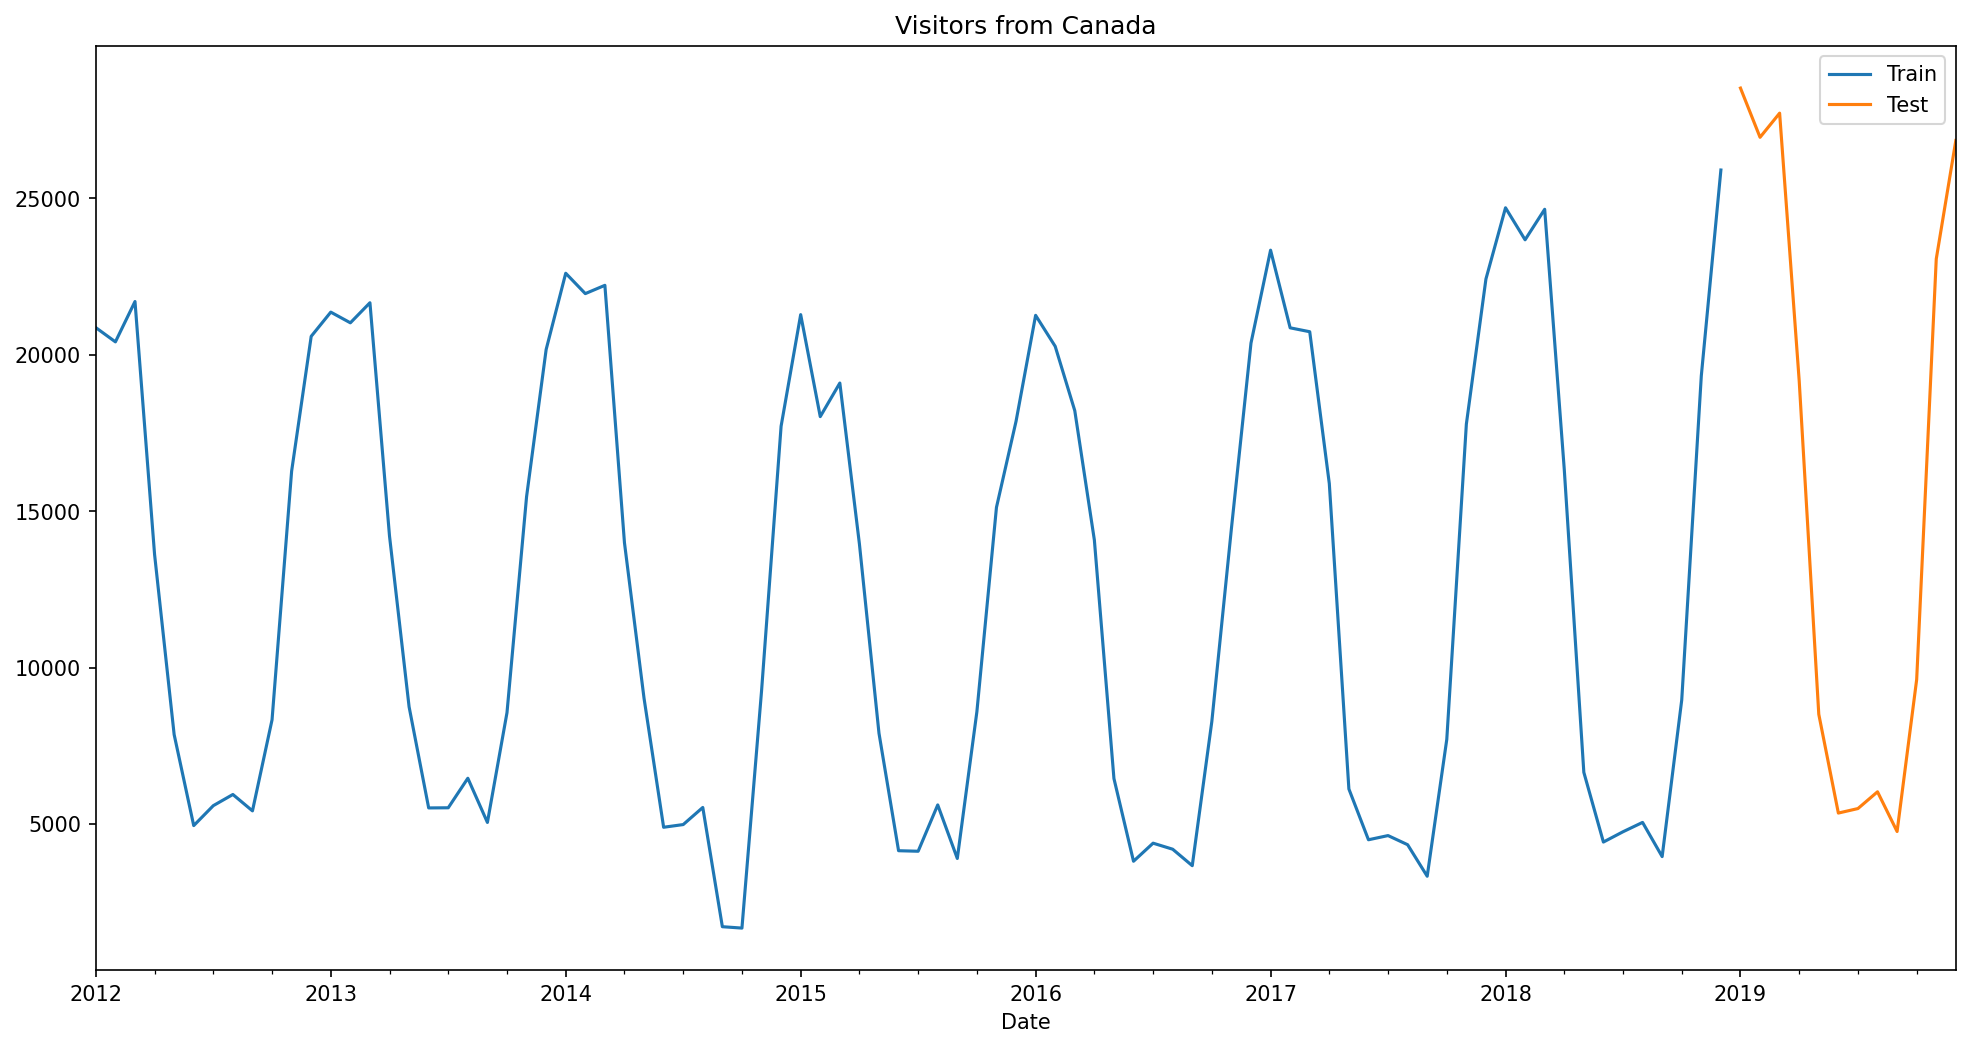

In [65]:
#Plot train and test data

# to set the plot size
plt.figure(figsize=(16, 8), dpi=150)
  
# using plot method to plot close prices.
# in plot method we set the label and color of the curve.
train_data.plot(label='Train')
test_data.plot(label='Test')

  
# adding title to the plot
plt.title('Visitors from Canada')
  
# adding Label to the x-axis
plt.xlabel('Date')
  
# adding legend to the curve
plt.legend()

## 15. Flights Model Fiting

### Simple Exponential Smoothing

In [66]:
#Third Instance
simple_ets_opt = SimpleExpSmoothing(train_data).fit()
simple_ets_opt_pred = simple_ets_opt.forecast(12).rename('alpha=%s'%simple_ets_opt.model.params['smoothing_level'])

C:\Users\punee\anaconda3\envs\TImeSeriesForecasting_Env\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


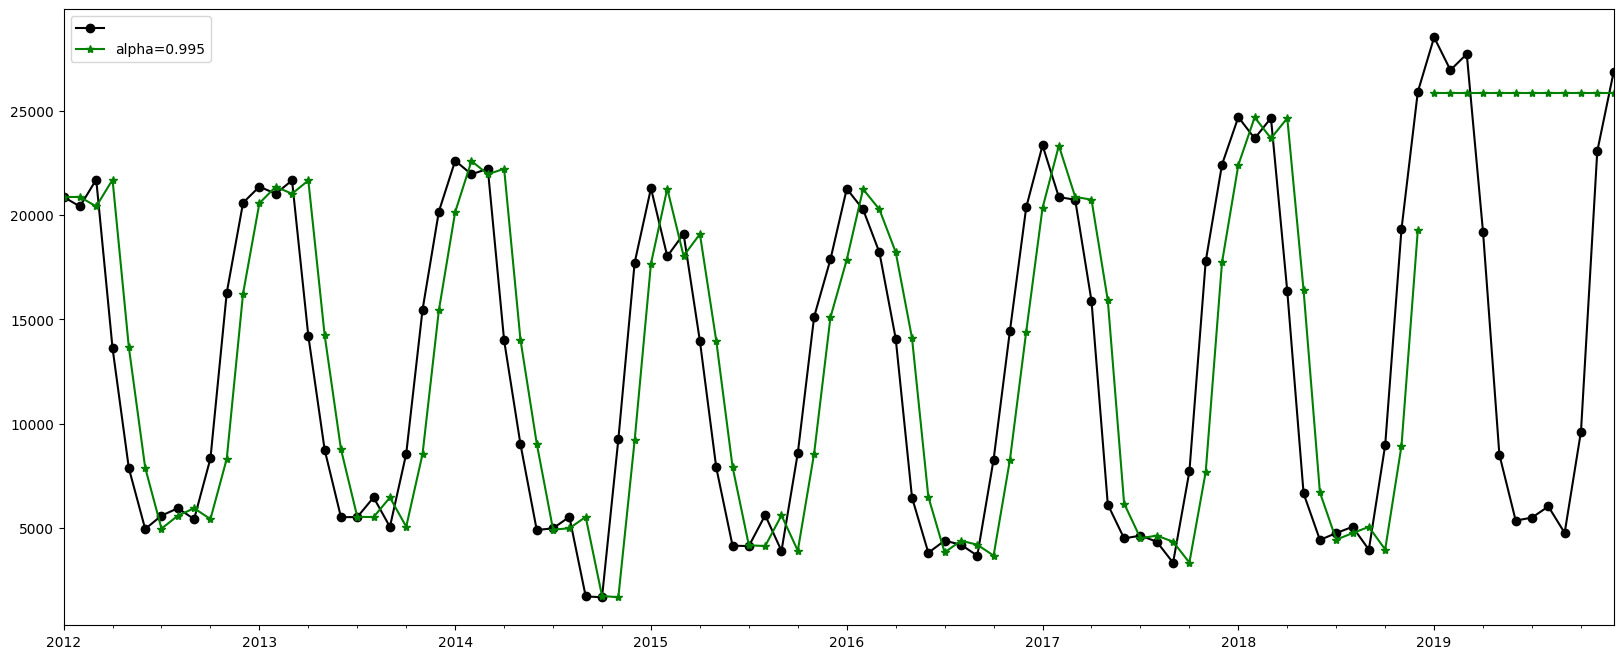

In [67]:
#After creating model we will visualize the plot
ax = flights_df2.plot(marker='o', color='black', figsize=(20,8), legend=True)

#Plot for alpha=Optimized by statsmodel
simple_ets_opt_pred.plot(marker='*', ax=ax, color='green', legend=True)
simple_ets_opt.fittedvalues.plot(marker='*', ax=ax, color='green')

plt.show()

### Double Exponential Smoothing

In [68]:
# Double ETS
double_ets_add = ExponentialSmoothing(train_data, trend = 'add').fit()
double_ets_mul = ExponentialSmoothing(train_data, trend = 'mul').fit()

double_ets_add_pred = double_ets_add.forecast(12)
double_ets_mul_pred = double_ets_mul.forecast(12)

C:\Users\punee\anaconda3\envs\TImeSeriesForecasting_Env\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\punee\anaconda3\envs\TImeSeriesForecasting_Env\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


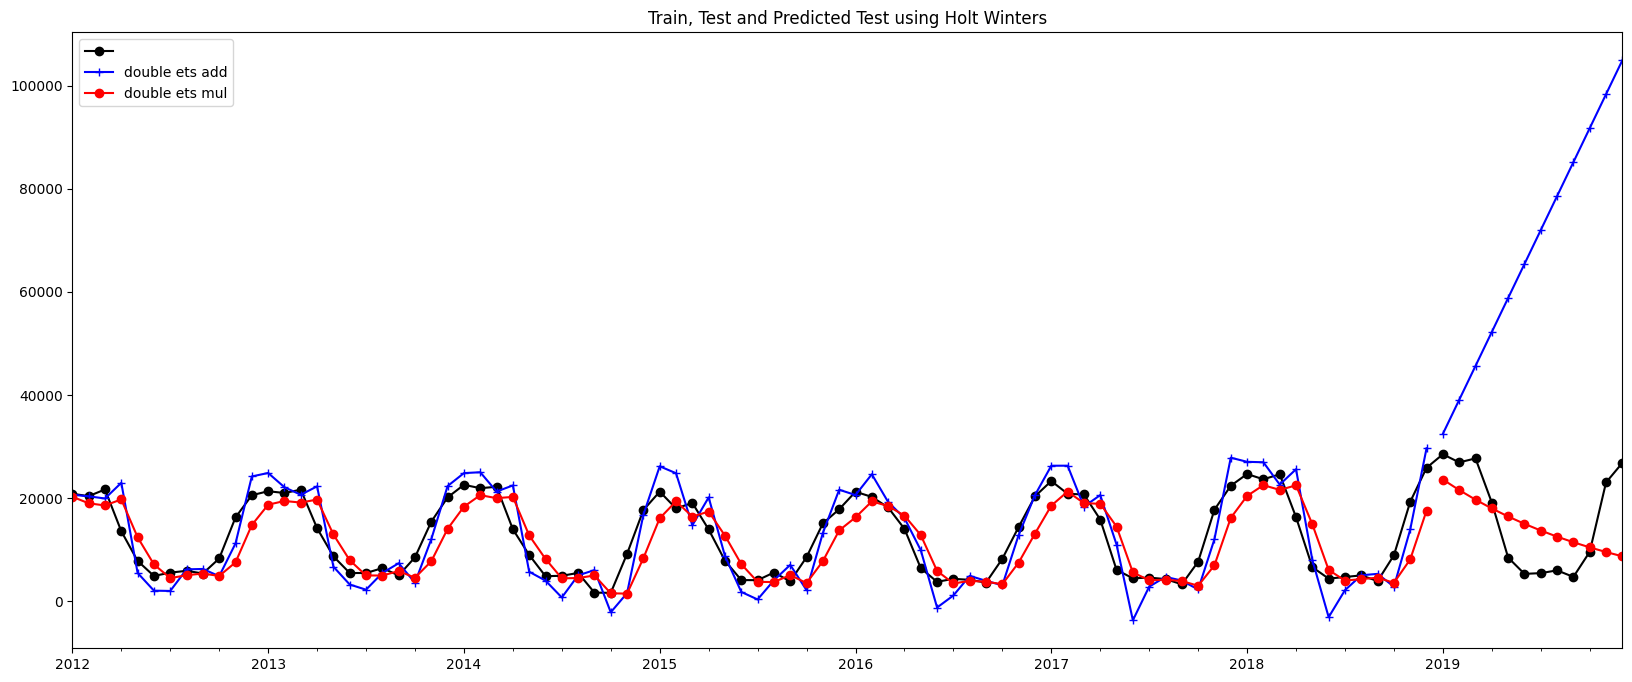

In [69]:
#plot the train, test, and predictions

#After creating model we will visualize the plot
ax = flights_df2.plot(marker='o', color='black', figsize=(20,8), legend=True)

#Plot for double ETS additive
double_ets_add_pred.plot(marker='+', ax=ax, color='blue', legend=True, label = 'double ets add')
double_ets_add.fittedvalues.plot(marker='+', ax=ax, color='blue')

#Plot for double ETS multiplicative
double_ets_mul_pred.plot(marker='o', ax=ax, color='red', legend=True, label = 'double ets mul')
double_ets_mul.fittedvalues.plot(marker='o', ax=ax, color='red')

plt.title('Train, Test and Predicted Test using Holt Winters')
plt.show()

### Triple Exponential Smoothing

In [70]:
# triple ETS - Holt Winter's Seasonal Method
triple_ets_add = ExponentialSmoothing(train_data, trend = 'add', seasonal = 'add', seasonal_periods=12).fit()
triple_ets_mul = ExponentialSmoothing(train_data, trend = 'mul', seasonal = 'mul', seasonal_periods=12).fit()

triple_ets_add_pred = triple_ets_add.forecast(12)
triple_ets_mul_pred = triple_ets_mul.forecast(12)

C:\Users\punee\anaconda3\envs\TImeSeriesForecasting_Env\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\punee\anaconda3\envs\TImeSeriesForecasting_Env\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


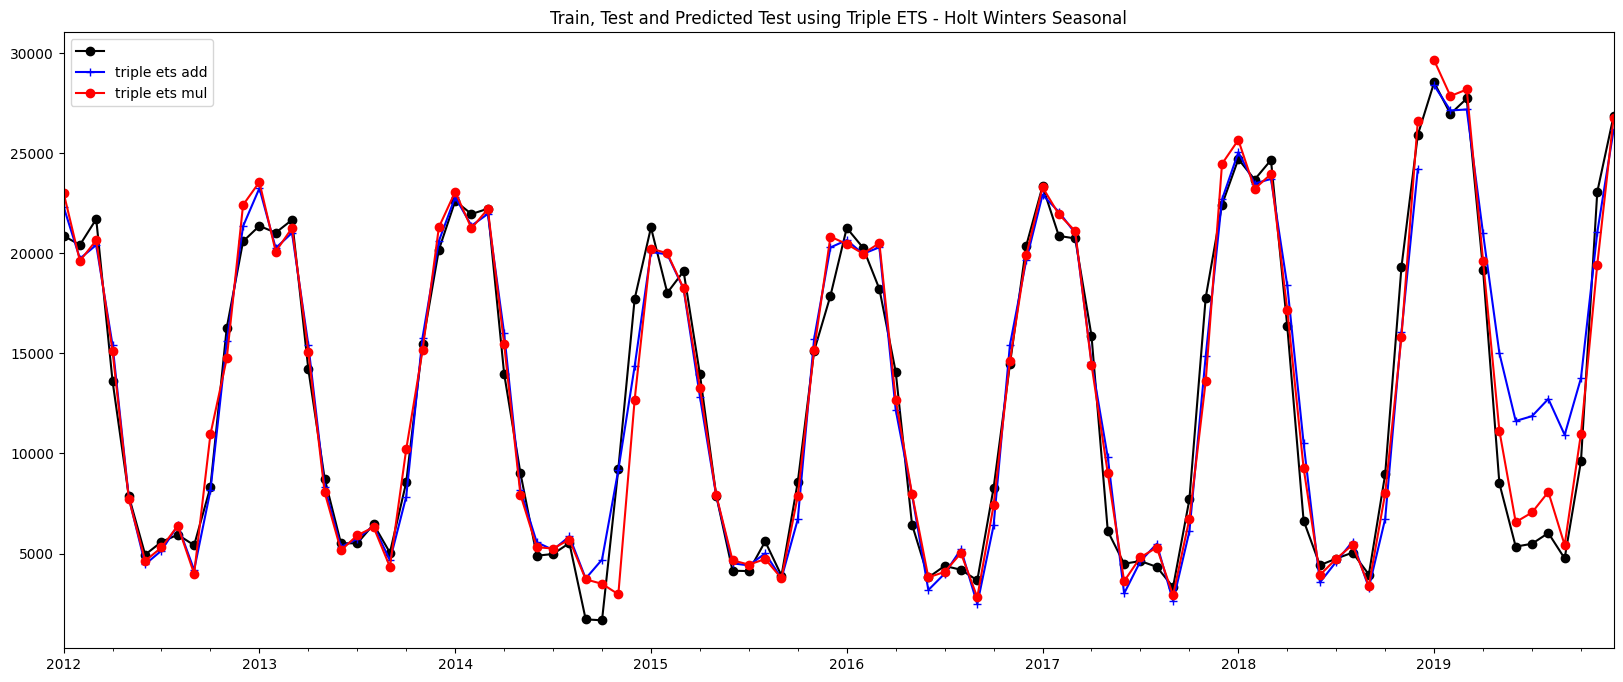

In [71]:
#plot the train, test, and predictions

#After creating model we will visualize the plot
ax = flights_df2.plot(marker='o', color='black', figsize=(20,8), legend=True)

#Plot for double ETS additive
triple_ets_add_pred.plot(marker='+', ax=ax, color='blue', legend=True, label = 'triple ets add')
triple_ets_add.fittedvalues.plot(marker='+', ax=ax, color='blue')

#Plot for double ETS multiplicative
triple_ets_mul_pred.plot(marker='o', ax=ax, color='red', legend=True, label = 'triple ets mul')
triple_ets_mul.fittedvalues.plot(marker='o', ax=ax, color='red')

plt.title('Train, Test and Predicted Test using Triple ETS - Holt Winters Seasonal')
plt.show()

### Auto ARIMA Seasonal

In [72]:
# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(train_data, start_p=0, start_q=0,
                         test='adf',
                         max_p=4, max_q=4, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1252.517, Time=0.02 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1260.796, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1256.660, Time=0.03 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1255.978, Time=0.03 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1253.886, Time=0.12 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=1253.976, Time=0.13 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=1254.514, Time=0.04 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=1255.885, Time=0.23 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=1255.534, Time=0.03 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1253.956, Time=0.17 sec
 ARIMA(0,1,0)(0,1,1)[12] intercept   : AIC=1255.603, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,1,1)[12]          
Total fit time: 0.857 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   84
Model:             SARIMAX(0, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -624.258
Date:                              Sun, 18 Jun 2023   AIC                           1252.517
Time:                                      23:22:31   BIC                           1257.042
Sample:                                  01-01-2012   HQIC                          1254.316
                                       - 12-01-2018                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -0.3114      0.082     -3.780      0.000      -0.473      -0.150
sigma2      2.353e+06   3.48e+05      6.765      0.000    1.67e+06    3.03e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):                 2.04
Prob(Q):                              0.72   Prob(JB):                         0.36
Heteroskedasticity (H):               1.01   Skew:                            -0.08
Prob(H) (two-sided):                  0.98   Kurtosis:                         3.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [73]:
# Forecast
n_periods = 12
fc_auto_seasonal, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)

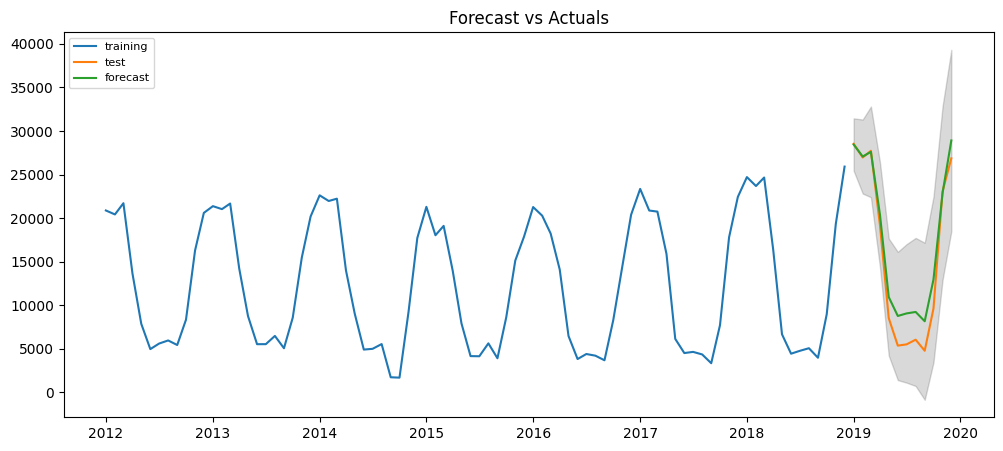

In [74]:
# make series for plotting purpose
fc_series_auto_seasonal = pd.Series(fc_auto_seasonal, index=test_data.index)
lower_series = pd.Series(confint[:, 0], index=test_data.index)
upper_series = pd.Series(confint[:, 1], index=test_data.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, label='test')
plt.plot(fc_series_auto_seasonal, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## 16. Flights Model Evaluation 

In [75]:
#define metrics dataframe which will be used below for 
metrics_dataframe = pd.DataFrame(columns=['Model', 'RMSE', 'MAE', 'MAPE'])

                                 
def metrics_cal(actuals, predictions, model):
    mse = mean_squared_error(actuals, predictions)
    rmse = sqrt(mse)
    mae = mean_absolute_error(actuals, predictions)
    mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100
    
    df = pd.DataFrame({'Model': model,
                       'RMSE': rmse,
                       'MAE': mae, 
                       'MAPE': mape}, index=[0])
    dataframe = metrics_dataframe.append(df)
    return dataframe

In [76]:
#get all the metrics
metrics_dataframe = metrics_cal(test_data.values.flatten(), 
                                simple_ets_opt_pred.values.flatten(), 
                                'Simple Opt')

metrics_dataframe = metrics_cal(test_data.values.flatten(), 
                                double_ets_add_pred.values.flatten(), 
                                'Double Add')

metrics_dataframe = metrics_cal(test_data.values.flatten(), 
                                double_ets_mul_pred.values.flatten(), 
                                'Double Mul')


metrics_dataframe = metrics_cal(test_data.values.flatten(), 
                                triple_ets_add_pred.values.flatten(), 
                                'Triple Add')

metrics_dataframe = metrics_cal(test_data.values.flatten(), 
                                triple_ets_mul_pred.values.flatten(), 
                                'Triple Mul')

metrics_dataframe = metrics_cal(test_data.values.flatten(), 
                                fc_series_auto_seasonal.values.flatten(), 
                                'Auto ARIMA Seasonal')

C:\Users\punee\AppData\Local\Temp\ipykernel_4124\3815975548.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataframe = metrics_dataframe.append(df)
C:\Users\punee\AppData\Local\Temp\ipykernel_4124\3815975548.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataframe = metrics_dataframe.append(df)
C:\Users\punee\AppData\Local\Temp\ipykernel_4124\3815975548.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataframe = metrics_dataframe.append(df)
C:\Users\punee\AppData\Local\Temp\ipykernel_4124\3815975548.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataframe = metrics_dataframe.append(df)
C:\Users\punee\AppData\Local

In [77]:
metrics_dataframe.sort_values(by='MAE')

,Model,RMSE,MAE,MAPE
0,Triple Mul,1657.375567,1343.359878,14.314561
0,Auto ARIMA Seasonal,2390.738963,1923.393510,27.632464
0,Triple Add,4383.498083,3463.881219,51.471064
0,Double Mul,8858.596153,7585.070474,73.469275
0,Simple Opt,13869.980134,10965.943408,164.350621
0,Double Add,59410.785472,52688.667975,632.049483


## 17. Flights Data Spliting for Backtesting

In [78]:
kfold_train_data_list = []
kfold_test_data_list = []
kfold_number = 4
period = 12

for kfold in range(kfold_number):
    if len(kfold_test_data_list) > 0:
        end_date = kfold_test_data_list[kfold - 1].index[0] - timedelta(days=1)
    else:
        end_date = flights_df2.index[-1]
    
    train_data, test_data = train_test_split(flights_df2[:end_date], 
                                             test_size=period, random_state=25, shuffle = False)
    #shuffle = False is very important to ensure the order of the data
    
    kfold_train_data_list.append(train_data)
    kfold_test_data_list.append(test_data)
    
    print(f"K Fold {kfold + 1}")
    print(f"No. of training examples: {train_data.shape[0]}")
    print(f"No. of testing examples: {test_data.shape[0]}")

K Fold 1
No. of training examples: 84
No. of testing examples: 12
K Fold 2
No. of training examples: 72
No. of testing examples: 12
K Fold 3
No. of training examples: 60
No. of testing examples: 12
K Fold 4
No. of training examples: 48
No. of testing examples: 12


<Figure size 3000x1800 with 0 Axes>

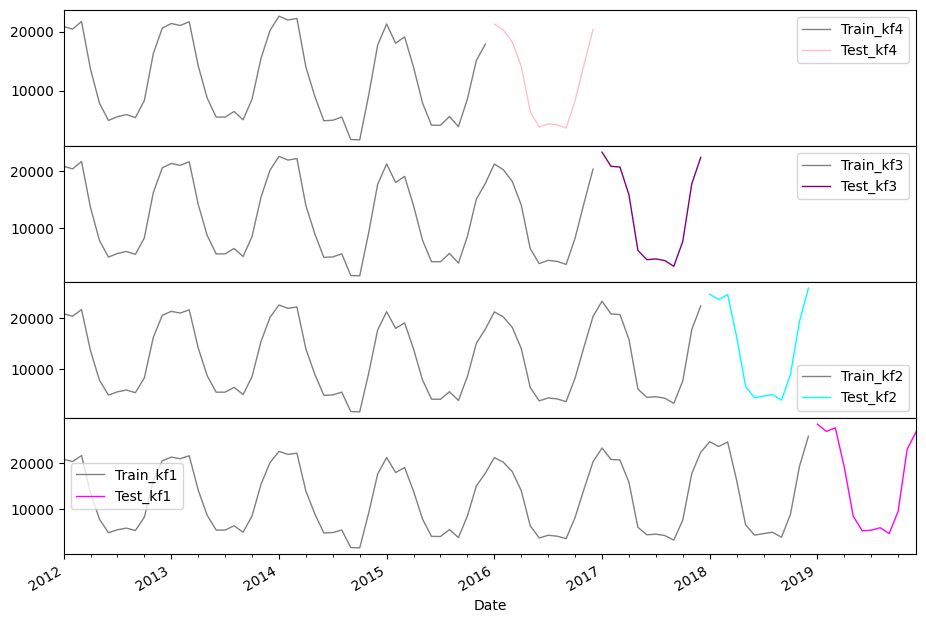

In [79]:
#Plot train and test data

# to set the plot size
plt.figure(figsize=(20, 12), dpi=150)
fig, axs = plt.subplots(4, 1, sharex=True)
fig.subplots_adjust(hspace=0)
  
# using plot method to plot close prices.
# in plot method we set the label and color of the curve.
kfold_train_data_list[3].plot(label='Train_kf4', linewidth=1, alpha=1, c='gray', ax=axs[0])
kfold_train_data_list[2].plot(label='Train_kf3', linewidth=1, alpha=1, c='gray', ax=axs[1])
kfold_train_data_list[1].plot(label='Train_kf2', linewidth=1, alpha=1, c='gray', ax=axs[2])
kfold_train_data_list[0].plot(label='Train_kf1', linewidth=1, alpha=1, c='gray', ax=axs[3])
kfold_test_data_list[3].plot(label='Test_kf4', linewidth=1, alpha=1, c='pink', ax=axs[0])
kfold_test_data_list[2].plot(label='Test_kf3', linewidth=1, alpha=1, c='purple', ax=axs[1])
kfold_test_data_list[1].plot(label='Test_kf2', linewidth=1, alpha=1, c='cyan', ax=axs[2])
kfold_test_data_list[0].plot(label='Test_kf1', linewidth=1, alpha=1, c='magenta', ax=axs[3])
  
# adding Label to the x-axis
plt.xlabel('Date')
fig.autofmt_xdate()
  
# adding legend to the curve
axs[0].legend()
axs[1].legend()
axs[2].legend()
axs[3].legend()

## 18. Flights Backtesting

In [80]:
def mod_metrics_cal(actuals, predictions, train):
    me = np.mean(actuals - predictions)
    mse = mean_squared_error(actuals, predictions)
    rmse = sqrt(mse)
    mae = mean_absolute_error(actuals, predictions)
    mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100
    naive_mae = np.mean(np.absolute(np.diff(np.trim_zeros(train))))
    naive_mse = np.mean((np.diff(np.trim_zeros(train))**2))
    mase = mae / naive_mae
    rmsse = np.sqrt(mse/naive_mse)
    
    return np.array([me, rmse, mae, mape, mase, rmsse])

In [81]:
kfold_number = 4

arima_nonseasonal_metrics = np.zeros((kfold_number, 6))
arima_seasonal_metrics = np.zeros((kfold_number, 6))
simple_ets_metrics = np.zeros((kfold_number, 6))
double_ets_add_metrics = np.zeros((kfold_number, 6))
double_ets_mul_metrics = np.zeros((kfold_number, 6))
triple_ets_add_metrics = np.zeros((kfold_number, 6))
triple_ets_mul_metrics = np.zeros((kfold_number, 6))

for kfold in range(kfold_number):
    mae_list = []
    pred_values_list = []
    # Non Seasonal ARIMA Model
    auto_nonseasonal_model = pm.auto_arima(kfold_train_data_list[kfold], start_p=0, start_q=0, 
                                           test='adf',       # use adftest to find optimal 'd'
                                           max_p=3, max_q=3, # maximum p and q
                                           m=12,              # frequency of series
                                           d=None,           # let model determine 'd'
                                           seasonal=False,   # No Seasonality
                                           trace=True,
                                           error_action='ignore',  
                                           suppress_warnings=True, 
                                           stepwise=True)
    fc_auto_non_seasonal, confint = auto_nonseasonal_model.predict(n_periods=12, return_conf_int=True)
    arima_nonseasonal_metrics[kfold] = mod_metrics_cal(kfold_test_data_list[kfold].values.flatten(), 
                                                       fc_auto_non_seasonal.values.flatten(),
                                                       kfold_train_data_list[kfold].values.flatten())
    mae_list.append(arima_nonseasonal_metrics[kfold, 2])
    pred_values_list.append(fc_auto_non_seasonal)
    
    # Seasonal ARIMA Model
    auto_seasonal_model = pm.auto_arima(kfold_train_data_list[kfold], start_p=0, start_q=0,
                                        test='adf',
                                        max_p=3, max_q=3, m=12,
                                        start_P=0, seasonal=True,
                                        d=None, D=1, trace=True,
                                        error_action='ignore',  
                                        suppress_warnings=True, 
                                        stepwise=True)
    fc_auto_seasonal, confint = auto_seasonal_model.predict(n_periods=12, return_conf_int=True)
    arima_seasonal_metrics[kfold] = mod_metrics_cal(kfold_test_data_list[kfold].values.flatten(), 
                                                    fc_auto_seasonal.values.flatten(),
                                                    kfold_train_data_list[kfold].values.flatten())
    mae_list.append(arima_seasonal_metrics[kfold, 2])
    pred_values_list.append(fc_auto_seasonal)
    
    # simple ets Optimized Alpha (0.306)
    simple_ets_opt = SimpleExpSmoothing(kfold_train_data_list[kfold]).fit()
    simple_ets_opt_pred = simple_ets_opt.forecast(12).rename('alpha_optimized')
    simple_ets_metrics[kfold] = mod_metrics_cal(kfold_test_data_list[kfold].values.flatten(), 
                                                simple_ets_opt_pred.values.flatten(),
                                                kfold_train_data_list[kfold].values.flatten())
    mae_list.append(simple_ets_metrics[kfold, 2])
    pred_values_list.append(simple_ets_opt_pred)
    
    # Double ETS
    double_ets_add = ExponentialSmoothing(kfold_train_data_list[kfold], trend = 'add').fit()
    double_ets_mul = ExponentialSmoothing(kfold_train_data_list[kfold], trend = 'mul').fit()
    double_ets_add_pred = double_ets_add.forecast(12)
    double_ets_mul_pred = double_ets_mul.forecast(12)
    
    double_ets_add_metrics[kfold] = mod_metrics_cal(kfold_test_data_list[kfold].values.flatten(), 
                                                    double_ets_add_pred.values.flatten(),
                                                    kfold_train_data_list[kfold].values.flatten())
    double_ets_mul_metrics[kfold] = mod_metrics_cal(kfold_test_data_list[kfold].values.flatten(), 
                                                    double_ets_mul_pred.values.flatten(),
                                                    kfold_train_data_list[kfold].values.flatten())
    mae_list.append(double_ets_add_metrics[kfold, 2])
    pred_values_list.append(double_ets_add_pred)
    mae_list.append(double_ets_mul_metrics[kfold, 2])
    pred_values_list.append(double_ets_mul_pred)
    
    # Triple ETS
    triple_ets_add = ExponentialSmoothing(kfold_train_data_list[kfold], trend = 'add', 
                                      seasonal = 'add', seasonal_periods=12).fit()
    triple_ets_mul = ExponentialSmoothing(kfold_train_data_list[kfold], trend = 'mul', 
                                      seasonal = 'mul', seasonal_periods=12).fit()
    triple_ets_add_pred = triple_ets_add.forecast(12)
    triple_ets_mul_pred = triple_ets_mul.forecast(12)
    triple_ets_add_metrics[kfold] = mod_metrics_cal(kfold_test_data_list[kfold].values.flatten(), 
                                                    triple_ets_add_pred.values.flatten(),
                                                    kfold_train_data_list[kfold].values.flatten())
    triple_ets_mul_metrics[kfold] = mod_metrics_cal(kfold_test_data_list[kfold].values.flatten(), 
                                                    triple_ets_mul_pred.values.flatten(),
                                                    kfold_train_data_list[kfold].values.flatten())
    mae_list.append(triple_ets_add_metrics[kfold, 2])
    pred_values_list.append(triple_ets_add_pred)
    mae_list.append(triple_ets_mul_metrics[kfold, 2])
    pred_values_list.append(triple_ets_mul_pred)
    
    # Adaptative Average of best 3 models
    best_model_idx = np.argsort(np.array(mae_list))
    best_avg_pred = (pred_values_list[best_model_idx[0]] + pred_values_list[best_model_idx[1]] +
                 pred_values_list[best_model_idx[2]]) / 3
    best_avg_metrics[kfold] = mod_metrics_cal(kfold_test_data_list[kfold].values.flatten(), 
                                              best_avg_pred.values.flatten(),
                                              kfold_train_data_list[kfold].values.flatten())

C:\Users\punee\anaconda3\envs\TImeSeriesForecasting_Env\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1849.058, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1655.632, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1754.983, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1618.346, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=1617.561, Time=0.02 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=1619.443, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1617.443, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1621.431, Time=0.02 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1619.360, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1617.862, Time=0.02 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=1621.283, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1585.210, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1615.769, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1588.537, Time=0.02 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept

C:\Users\punee\anaconda3\envs\TImeSeriesForecasting_Env\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\punee\anaconda3\envs\TImeSeriesForecasting_Env\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\punee\anaconda3\envs\TImeSeriesForecasting_Env\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\punee\anaconda3\envs\TImeSeriesForecasting_Env\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\punee\anaconda3\envs\TImeSeriesForecasting_Env\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_r

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1581.191, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1413.999, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1501.784, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1384.068, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=1384.153, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1384.180, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1386.594, Time=0.02 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=1386.162, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1358.759, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1408.885, Time=0.01 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=1357.666, Time=0.03 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=1347.980, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1357.032, Time=0.08 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=1371.044, Time=0.19 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept

C:\Users\punee\anaconda3\envs\TImeSeriesForecasting_Env\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\punee\anaconda3\envs\TImeSeriesForecasting_Env\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\punee\anaconda3\envs\TImeSeriesForecasting_Env\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\punee\anaconda3\envs\TImeSeriesForecasting_Env\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\punee\anaconda3\envs\TImeSeriesForecasting_Env\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_r

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1316.475, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1176.024, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1252.095, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1151.555, Time=0.01 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=1152.271, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1152.616, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1155.473, Time=0.02 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1130.707, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1171.676, Time=0.01 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=1129.577, Time=0.03 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=1123.526, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1130.683, Time=0.05 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=1148.232, Time=0.13 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : 

C:\Users\punee\anaconda3\envs\TImeSeriesForecasting_Env\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\punee\anaconda3\envs\TImeSeriesForecasting_Env\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\punee\anaconda3\envs\TImeSeriesForecasting_Env\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\punee\anaconda3\envs\TImeSeriesForecasting_Env\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\punee\anaconda3\envs\TImeSeriesForecasting_Env\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_r

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1054.127, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=942.822, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1003.794, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=926.181, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=927.117, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=927.467, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=928.627, Time=0.02 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=918.532, Time=0.08 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=928.291, Time=0.07 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=927.166, Time=0.06 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=906.822, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=911.118, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=910.313, Time=0.03 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=916.139, Time=0.12 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=910

C:\Users\punee\anaconda3\envs\TImeSeriesForecasting_Env\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\punee\anaconda3\envs\TImeSeriesForecasting_Env\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\punee\anaconda3\envs\TImeSeriesForecasting_Env\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\punee\anaconda3\envs\TImeSeriesForecasting_Env\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\punee\anaconda3\envs\TImeSeriesForecasting_Env\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_r

<Figure size 3000x1800 with 0 Axes>

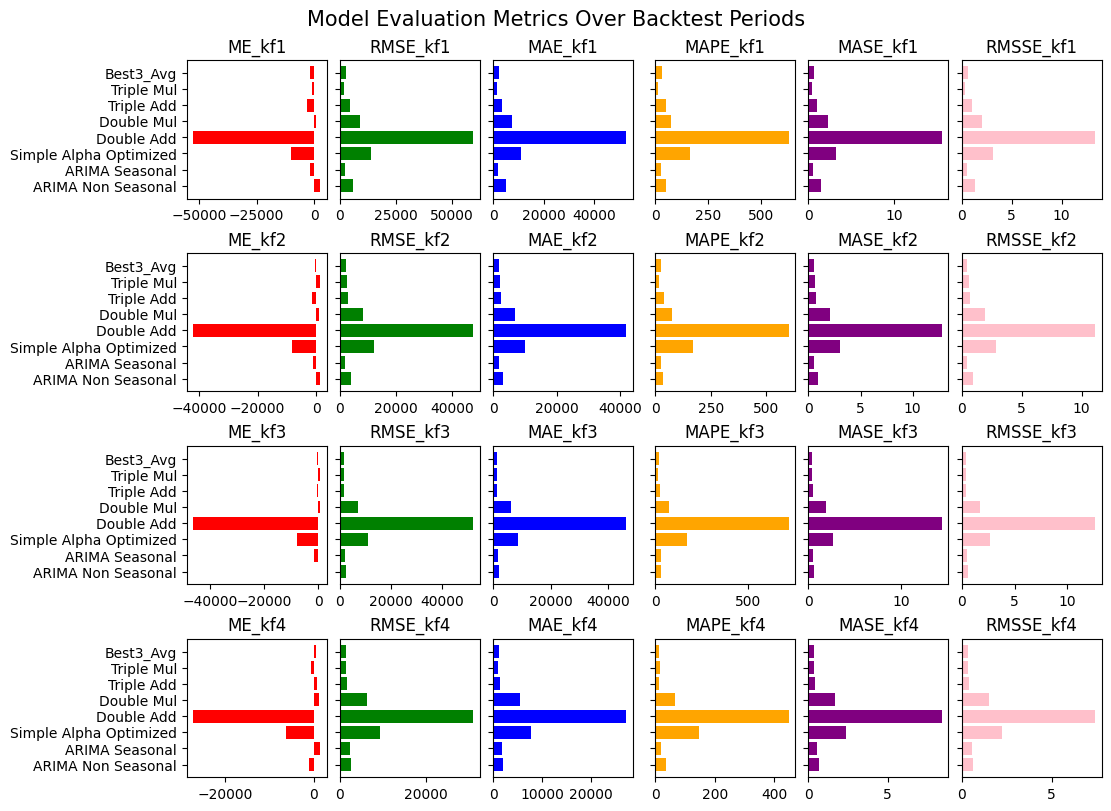

In [82]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [11, 8]
plt.rcParams['figure.dpi'] = 100

kfold_number = 4

plt.figure(figsize=(20, 12), dpi=150)
fig, axs = plt.subplots(4, 6, sharey=True, constrained_layout = True)
#fig.subplots_adjust(hspace=0)

for kf in range(kfold_number):
    metrics_kf = np.stack((arima_nonseasonal_metrics[kf], arima_seasonal_metrics[kf],
                           simple_ets_metrics[kf], double_ets_add_metrics[kf], 
                           double_ets_mul_metrics[kf], triple_ets_add_metrics[kf], 
                           triple_ets_mul_metrics[kf], best_avg_metrics[kf]))
    metrics_kf_df = pd.DataFrame(metrics_kf, 
                                 columns=['ME', 'RMSE', 'MAE', 'MAPE', 'MASE', 'RMSSE'],
                                 index=['ARIMA Non Seasonal', 'ARIMA Seasonal', 'Simple Alpha Optimized',
                                         'Double Add', 'Double Mul', 'Triple Add', 'Triple Mul', 'Best3_Avg'])

    me_df = metrics_kf_df[['ME']]
    rmse_df = metrics_kf_df[['RMSE']]
    mae_df = metrics_kf_df[['MAE']]
    mape_df = metrics_kf_df[['MAPE']]
    mase_df = metrics_kf_df[['MASE']]
    rmsse = metrics_kf_df[['RMSSE']]

    axs[kf,0].barh(metrics_kf_df.index ,metrics_kf_df['ME'], color='red')
    axs[kf,0].set_title(f'ME_kf{kf + 1}')
    axs[kf,1].barh(metrics_kf_df.index ,metrics_kf_df['RMSE'], color='green')
    axs[kf,1].set_title(f'RMSE_kf{kf + 1}')
    axs[kf,2].barh(metrics_kf_df.index ,metrics_kf_df['MAE'], color='blue')
    axs[kf,2].set_title(f'MAE_kf{kf + 1}')
    axs[kf,3].barh(metrics_kf_df.index ,metrics_kf_df['MAPE'], color='orange')
    axs[kf,3].set_title(f'MAPE_kf{kf + 1}')
    axs[kf,4].barh(metrics_kf_df.index ,metrics_kf_df['MASE'], color='purple')
    axs[kf,4].set_title(f'MASE_kf{kf + 1}')
    axs[kf,5].barh(metrics_kf_df.index ,metrics_kf_df['RMSSE'], color='pink')
    axs[kf,5].set_title(f'RMSSE_kf{kf + 1}')

plt.suptitle('Model Evaluation Metrics Over Backtest Periods', fontsize=15)
plt.show()

In [83]:
arima_nonseasonal_mean_metrics = np.mean(arima_nonseasonal_metrics, axis=0)
arima_seasonal_mean_metrics = np.mean(arima_seasonal_metrics, axis=0)
simple_ets_mean_metrics = np.mean(simple_ets_metrics, axis=0)
double_ets_add_mean_metrics = np.mean(double_ets_add_metrics, axis=0)
double_ets_mul_mean_metrics = np.mean(double_ets_mul_metrics, axis=0)
triple_ets_add_mean_metrics = np.mean(triple_ets_add_metrics, axis=0)
triple_ets_mul_mean_metrics = np.mean(triple_ets_mul_metrics, axis=0)
best_avg_mean_metrics = np.mean(best_avg_metrics, axis=0)

mean_backtest_metrics = np.stack((arima_nonseasonal_mean_metrics, arima_seasonal_mean_metrics,
                                  simple_ets_mean_metrics, double_ets_add_mean_metrics, 
                                  double_ets_mul_mean_metrics, triple_ets_add_mean_metrics, 
                                  triple_ets_mul_mean_metrics, best_avg_mean_metrics))

mean_backtest_metrics_df = pd.DataFrame(mean_backtest_metrics, 
                                        columns=['ME', 'RMSE', 'MAE', 'MAPE', 'MASE', 'RMSSE'],
                                        index=['ARIMA Non Seasonal', 'ARIMA Seasonal', 'Simple Alpha Optimized',
                                               'Double Add', 'Double Mul', 'Triple Add', 'Triple Mul', 'Best3_Avg'])

In [84]:
mean_backtest_metrics_df.sort_values(by='MAE')

,ME,RMSE,MAE,MAPE,MASE,RMSSE
Triple Mul,187.485926,1849.452973,1470.185306,14.598492,0.447610,0.433773
Best3_Avg,-505.995674,1958.582796,1639.354476,22.144574,0.497364,0.456839
ARIMA Seasonal,-715.270430,2136.059523,1771.175556,25.678502,0.539135,0.500635
Triple Add,-990.202519,2647.521988,2169.980542,31.419291,0.656228,0.614343
ARIMA Non Seasonal,662.964210,3716.665801,3063.349433,37.705820,0.926032,0.863550
Double Mul,988.777016,7640.932760,6494.130727,73.502395,1.974111,1.787919
Simple Alpha Optimized,-8048.034729,11580.259335,9321.678243,163.576205,2.833240,2.708482
Double Add,-42060.238957,47514.760936,42067.038149,600.485174,12.777511,11.110348


### Conclusions: Flights Dataset

- The model that performed the best for all accuracy metrics (ME, RMSE, MAE, MAPE, MASE and RMSSE), and across the different test periods, was the Triple Exponential Smoothing with Multiplicative Trend and Seasonality.